In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [5]:
class RandomDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y(), np.random.randint(2))
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [6]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

In [7]:
# Random Control Experiment
random_ds = RandomDataset(2*m)
binary_train = random_ds[:m]
binary_val = random_ds[m:]

100%|██████████| 1892188/1892188 [03:39<00:00, 8605.54it/s]


In [10]:
# Check the random control experiment datasets
binary_train[2]

('CGTGCCAACGCGGAGCAGGCTGCTGACTTCAAATTAGACG', 'MTSCMRKI', 0)

## NN Model

In [11]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [12]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [13]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [14]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
        

In [15]:
class SingleAlphabetNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetNet, self).__init__()
        self.name = "SingleAlphabetNet"
        
        self.cnn_1 = nn.Conv1d(24, 25, 3) 
        self.cnn_2 = nn.Conv1d(25, 50, 3)
        self.cnn_3 = nn.Conv1d(50, 100, 3)
        self.cnn_4 = nn.Conv1d(100, 200, 3)
        self.cnn_5 = nn.Conv1d(200, 400, 1)
        self.cnn_6 = nn.Conv1d(400, 800, 1)
        
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))        

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [16]:
class SingleAlphabetComplexNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetComplexNet, self).__init__()
        self.name = "SingleAlphabetComplexNet"
        
        self.cnn_1 = nn.Conv1d(24, 50, 3) 
        self.cnn_2 = nn.Conv1d(50, 100, 3)
        self.cnn_3 = nn.Conv1d(100, 200, 3)
        self.cnn_4 = nn.Conv1d(200, 400, 3)
        self.cnn_5 = nn.Conv1d(400, 800, 3)
        self.cnn_6 = nn.Conv1d(800, 1000, 3, padding=2)
        self.cnn_7 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_8 = nn.Conv1d(800, 700, 3, padding=2)
        self.cnn_9 = nn.Conv1d(700, 500, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))
        pair = self.pool1(self.relu(self.cnn_7(pair))) 
        pair = self.pool1(self.relu(self.cnn_8(pair)))
        pair = self.pool1(self.relu(self.cnn_9(pair))) 

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [17]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [18]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') #(40, 4)
        pep = one_hot(pep, seq_type='peptide') #(8, 20)
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

#Returns area under the CDF
def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    plt.xlim([0,1])
    plt.show()
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [19]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None, 
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] + 1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9, last_epoch=-1) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            
            if label == 0.0:
                train_gen_scores.append(train_score.item())
            elif label == 1.0:
                train_scores.append(train_score.item())
                
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
            
            if cdf:
                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    if single_alphabet:
                        p_val, l_val = convert(x, y, 0, single_alphabet=True)
                        gen_score = model(p_val)
                    else:
                        a_val, p_val, l_val = convert(x, y, 0)
                        gen_score = model(a_val, p_val)
                    gen_outputs.append(gen_score.item())

                # Generate CDF plots
                if len(train_scores) > 1000:
                    train_cdf = np.asarray(gen_outputs[-10000:] + train_scores[-1000:]) 
                    test_cdf = np.asarray(gen_outputs[-10000:] + val_scores[-1000:])
                else:
                    train_cdf = np.asarray(gen_outputs + train_scores) #combine train and unknown scores
                    test_cdf = np.asarray(gen_outputs + val_scores)
            
            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                print("Training AUC at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation AUC epoch %d: {}".format(val_auc) % full_epoch)
    
                if cdf:
                    plot_ecdf_train(train_cdf, iters, full_epoch, lr, model_name, model_id)
                    plot_ecdf_test(test_cdf, iters, full_epoch, lr, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) % full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) % full_epoch)
        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 1/946094 [00:00<48:25:55,  5.43it/s]

Starting epoch: 0  with learning rate:  [0.1]


  5%|▌         | 49986/946094 [07:17<1:58:03, 126.51it/s]

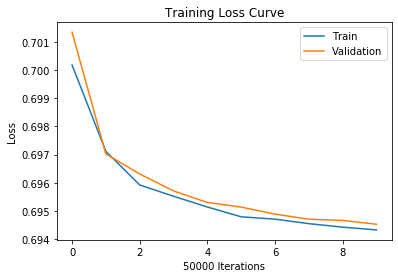

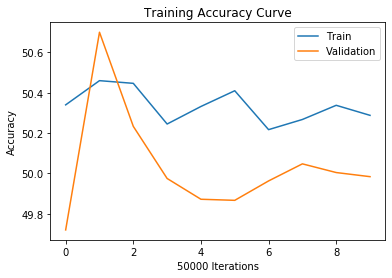

  5%|▌         | 49986/946094 [07:30<1:58:03, 126.51it/s]

  5%|▌         | 50017/946094 [08:13<209:21:32,  1.19it/s]

Training AUC at epoch 0: 0.2732366363636364
Validation AUC epoch 0: 0.26937027272727276
Training Accuracy at epoch 0: 50.288
Validation Accuracy epoch 0: 49.984


 11%|█         | 99992/946094 [15:25<2:36:04, 90.35it/s]  

 11%|█         | 99992/946094 [15:40<2:36:04, 90.35it/s]

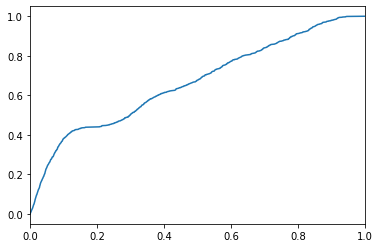

 11%|█         | 100017/946094 [16:20<337:12:42,  1.43s/it]

Training AUC at epoch 0: 0.6661555454545455
Validation AUC epoch 0: 0.6795181818181819
Training Accuracy at epoch 0: 49.9
Validation Accuracy epoch 0: 49.982


 16%|█▌        | 149993/946094 [23:31<1:32:42, 143.11it/s] 

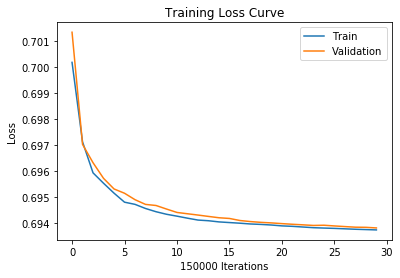

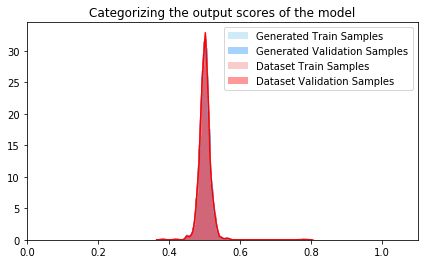

 16%|█▌        | 149993/946094 [23:50<1:32:42, 143.11it/s]

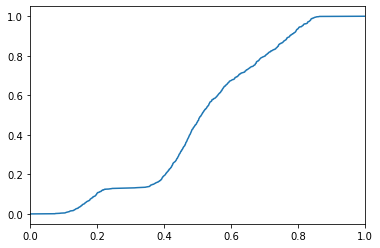

 16%|█▌        | 150000/946094 [24:27<527:25:02,  2.39s/it]

Training AUC at epoch 0: 0.4790893636363636
Validation AUC epoch 0: 0.4800850909090909
Training Accuracy at epoch 0: 49.922666666666665
Validation Accuracy epoch 0: 49.92066666666667


 21%|██        | 199984/946094 [31:39<1:54:55, 108.20it/s] 

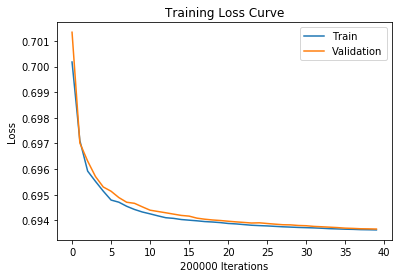

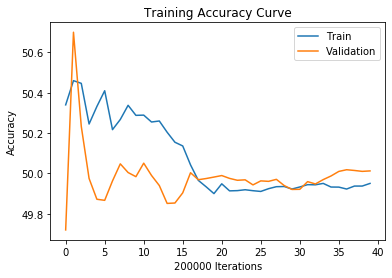

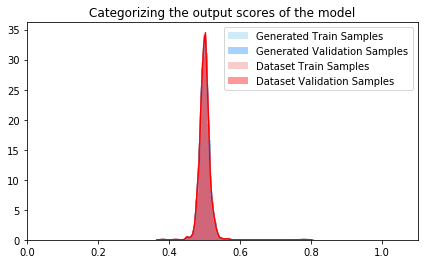

 21%|██        | 199984/946094 [31:51<1:54:55, 108.20it/s]

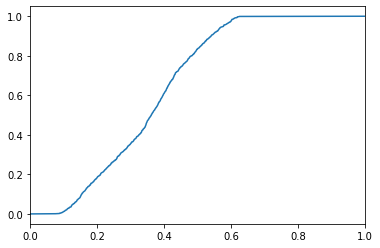

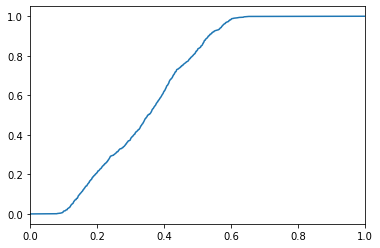

 21%|██        | 200017/946094 [32:35<154:21:12,  1.34it/s]

Training AUC at epoch 0: 0.6549168181818182
Validation AUC epoch 0: 0.6477434545454546
Training Accuracy at epoch 0: 49.9505
Validation Accuracy epoch 0: 50.0125


 26%|██▋       | 249986/946094 [39:53<2:13:58, 86.60it/s]  

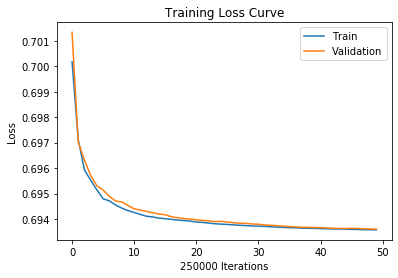

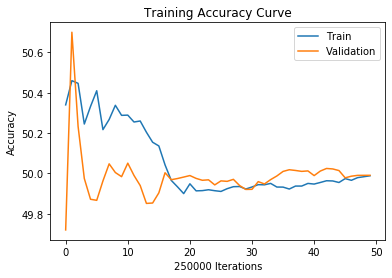

 26%|██▋       | 249986/946094 [40:11<2:13:58, 86.60it/s]

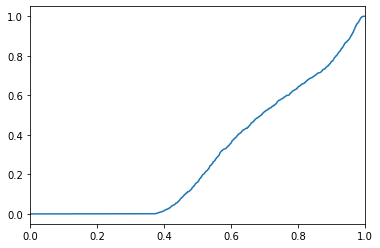

 26%|██▋       | 250013/946094 [40:50<164:43:35,  1.17it/s]

Training AUC at epoch 0: 0.2958757272727273
Validation AUC epoch 0: 0.29192772727272726
Training Accuracy at epoch 0: 49.9884
Validation Accuracy epoch 0: 49.9908


 32%|███▏      | 299990/946094 [48:11<1:11:11, 151.26it/s] 

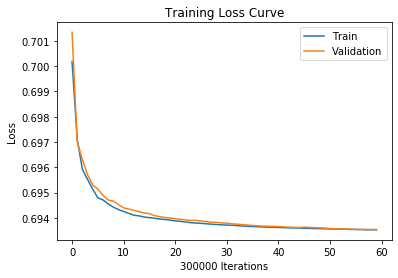

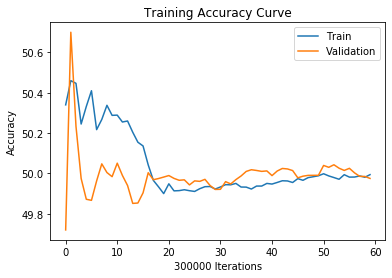

 32%|███▏      | 299990/946094 [48:21<1:11:11, 151.26it/s]

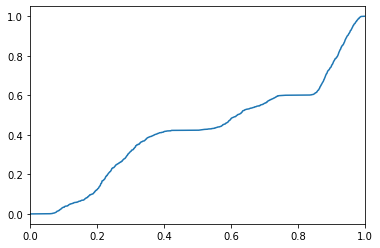

 32%|███▏      | 300018/946094 [49:09<218:09:32,  1.22s/it]

Training AUC at epoch 0: 0.419737
Validation AUC epoch 0: 0.4223227272727273
Training Accuracy at epoch 0: 49.994
Validation Accuracy epoch 0: 49.97533333333333


 37%|███▋      | 349982/946094 [56:25<1:53:00, 87.92it/s]  

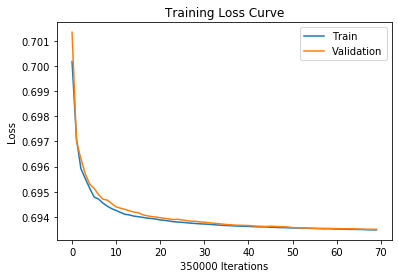

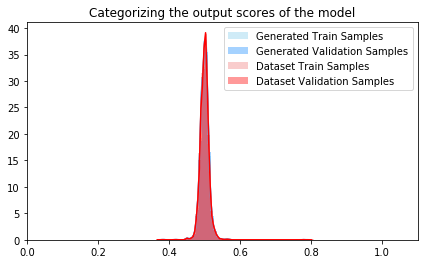

 37%|███▋      | 349982/946094 [56:41<1:53:00, 87.92it/s]

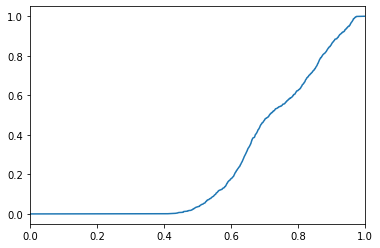

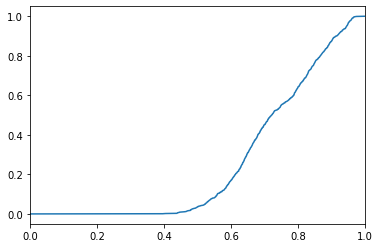

 37%|███▋      | 350018/946094 [57:21<108:54:29,  1.52it/s]

Training AUC at epoch 0: 0.266968
Validation AUC epoch 0: 0.26715127272727274
Training Accuracy at epoch 0: 50.03285714285714
Validation Accuracy epoch 0: 49.97228571428571


 42%|████▏     | 399986/946094 [1:04:32<57:22, 158.65it/s]  

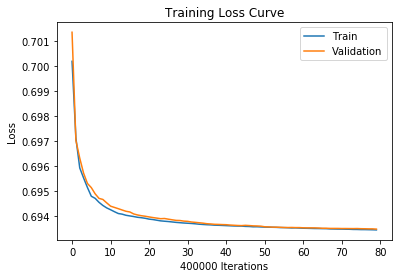

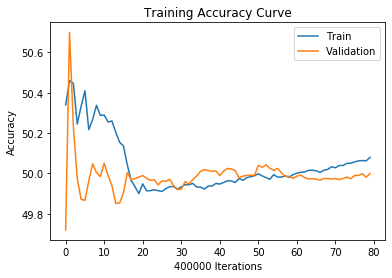

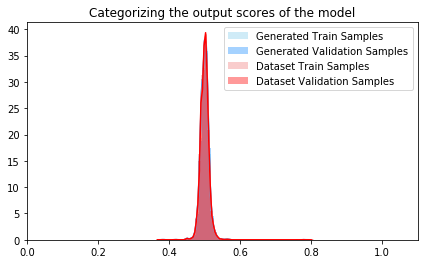

 42%|████▏     | 399986/946094 [1:04:51<57:22, 158.65it/s]

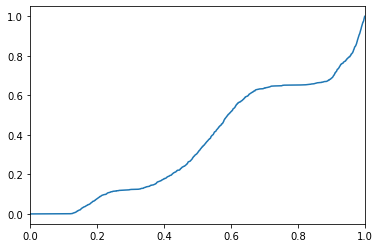

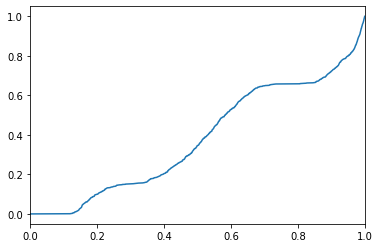

 42%|████▏     | 400017/946094 [1:05:28<127:46:13,  1.19it/s]

Training AUC at epoch 0: 0.38048581818181815
Validation AUC epoch 0: 0.36380754545454547
Training Accuracy at epoch 0: 50.07975
Validation Accuracy epoch 0: 49.9995


 48%|████▊     | 449992/946094 [1:12:09<59:18, 139.39it/s]   

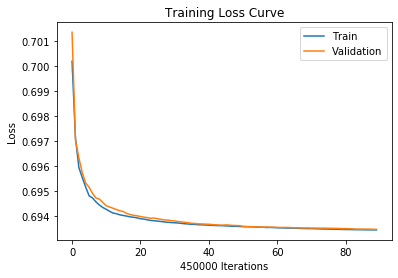

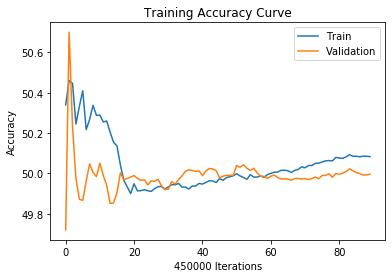

 48%|████▊     | 449992/946094 [1:12:22<59:18, 139.39it/s]

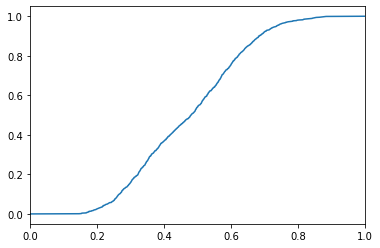

 48%|████▊     | 450017/946094 [1:13:06<203:53:42,  1.48s/it]

Training AUC at epoch 0: 0.5343527272727273
Validation AUC epoch 0: 0.5249196363636364
Training Accuracy at epoch 0: 50.083333333333336
Validation Accuracy epoch 0: 49.995555555555555


 53%|█████▎    | 499995/946094 [1:19:47<1:21:12, 91.55it/s]  

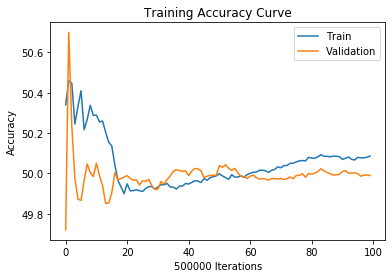

 53%|█████▎    | 499995/946094 [1:20:02<1:21:12, 91.55it/s]

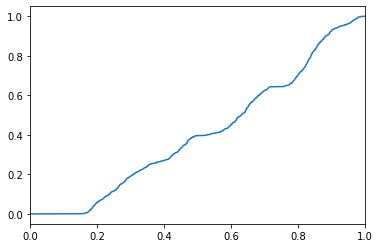

 53%|█████▎    | 500017/946094 [1:20:44<296:13:45,  2.39s/it]

Training AUC at epoch 0: 0.40943254545454544
Validation AUC epoch 0: 0.4120216363636363
Training Accuracy at epoch 0: 50.0862
Validation Accuracy epoch 0: 49.9896


 58%|█████▊    | 549995/946094 [1:27:29<43:56, 150.24it/s]   

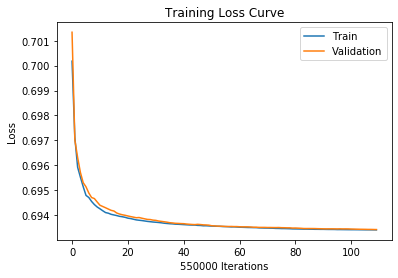

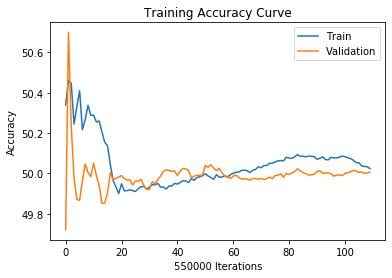

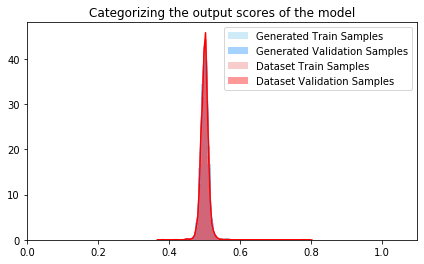

 58%|█████▊    | 549995/946094 [1:27:42<43:56, 150.24it/s]

 58%|█████▊    | 550000/946094 [1:28:26<378:01:12,  3.44s/it]

Training AUC at epoch 0: 0.5511405454545455
Validation AUC epoch 0: 0.5473
Training Accuracy at epoch 0: 50.024
Validation Accuracy epoch 0: 50.006


 63%|██████▎   | 599983/946094 [1:35:16<44:18, 130.19it/s]   

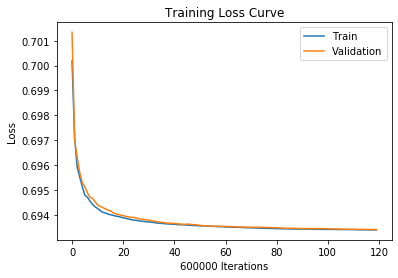

 63%|██████▎   | 599983/946094 [1:35:32<44:18, 130.19it/s]

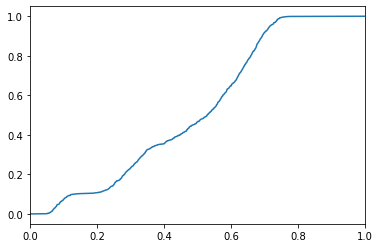

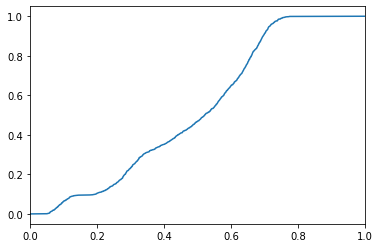

 63%|██████▎   | 600017/946094 [1:36:13<68:17:08,  1.41it/s]

Training AUC at epoch 0: 0.5272637272727272
Validation AUC epoch 0: 0.5295680909090908
Training Accuracy at epoch 0: 50.02133333333333
Validation Accuracy epoch 0: 49.98733333333333


 69%|██████▊   | 649984/946094 [1:43:07<51:30, 95.82it/s]   

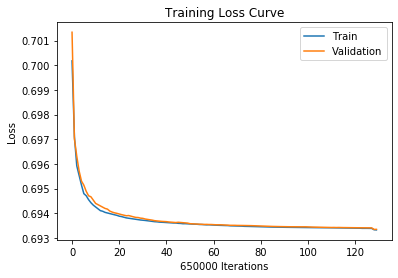

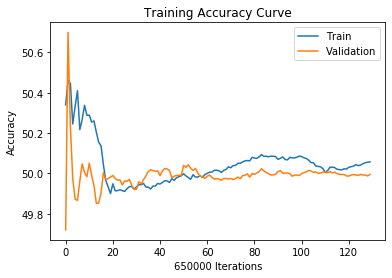

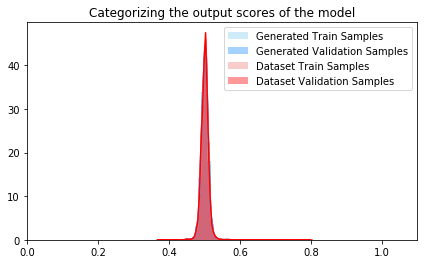

 69%|██████▊   | 649984/946094 [1:43:23<51:30, 95.82it/s]

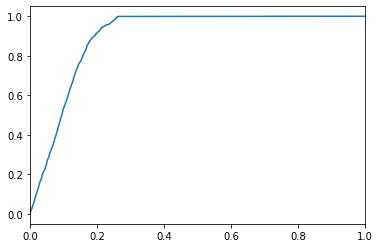

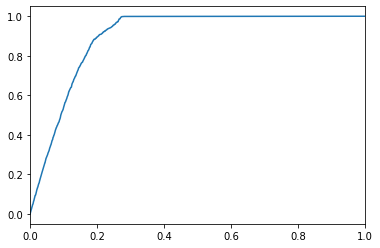

 69%|██████▊   | 650017/946094 [1:44:05<63:47:25,  1.29it/s]

Training AUC at epoch 0: 0.8983900909090908
Validation AUC epoch 0: 0.8997062727272727
Training Accuracy at epoch 0: 50.05738461538461
Validation Accuracy epoch 0: 49.995384615384616


 74%|███████▍  | 699984/946094 [1:50:53<28:44, 142.71it/s]  

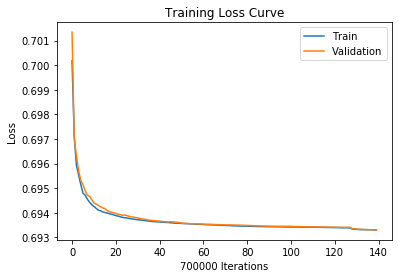

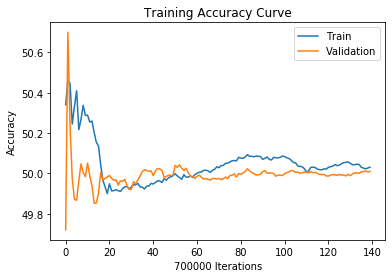

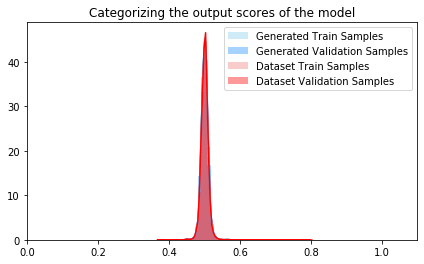

 74%|███████▍  | 699984/946094 [1:51:03<28:44, 142.71it/s]

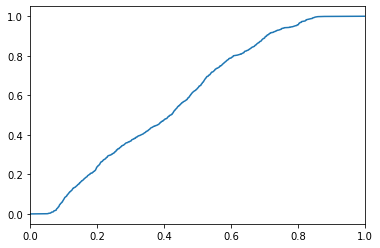

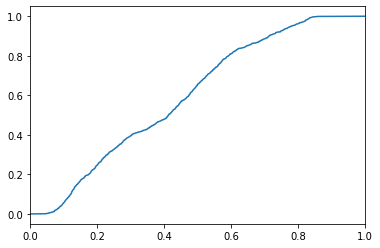

 74%|███████▍  | 700021/946094 [1:51:51<52:25:55,  1.30it/s]

Training AUC at epoch 0: 0.5998077272727274
Validation AUC epoch 0: 0.5933074545454545
Training Accuracy at epoch 0: 50.03114285714286
Validation Accuracy epoch 0: 50.01042857142857


 79%|███████▉  | 749992/946094 [1:58:26<28:53, 113.11it/s]  

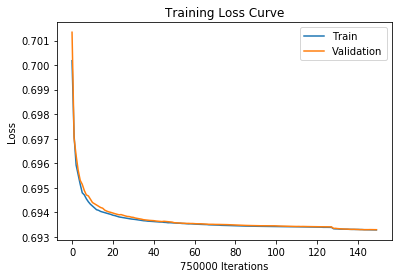

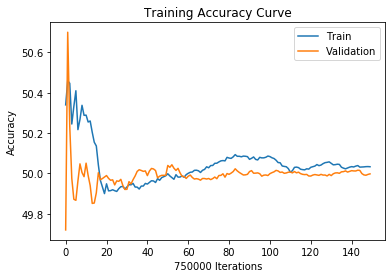

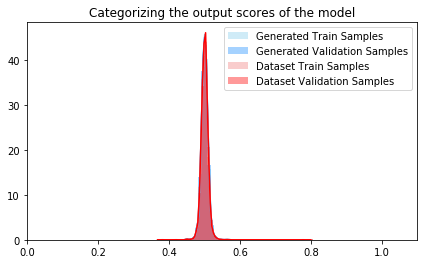

 79%|███████▉  | 749992/946094 [1:58:43<28:53, 113.11it/s]

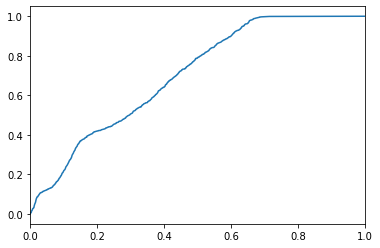

 79%|███████▉  | 750018/946094 [1:59:24<83:24:50,  1.53s/it] 

Training AUC at epoch 0: 0.7098994545454546
Validation AUC epoch 0: 0.702088090909091
Training Accuracy at epoch 0: 50.0332
Validation Accuracy epoch 0: 49.99786666666667


 85%|████████▍ | 799995/946094 [2:05:55<15:40, 155.41it/s]  

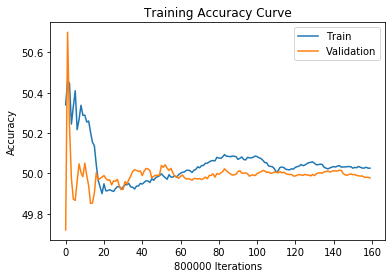

 85%|████████▍ | 799995/946094 [2:06:14<15:40, 155.41it/s]

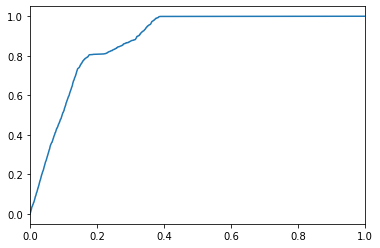

 85%|████████▍ | 800017/946094 [2:06:54<99:32:14,  2.45s/it] 

Training AUC at epoch 0: 0.8775512727272726
Validation AUC epoch 0: 0.8806244545454545
Training Accuracy at epoch 0: 50.026125
Validation Accuracy epoch 0: 49.977125


 90%|████████▉ | 849995/946094 [2:13:28<11:16, 142.03it/s]  

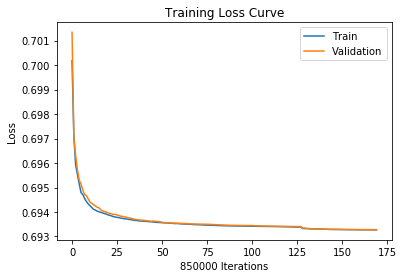

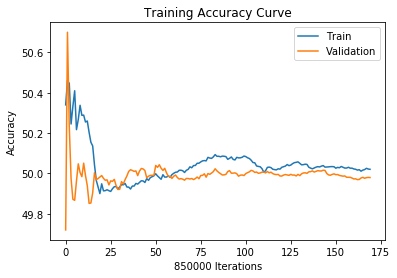

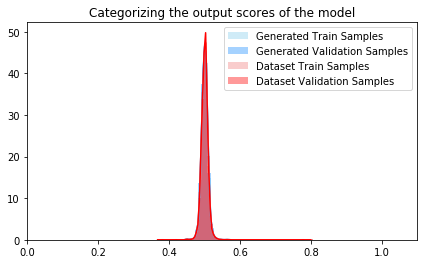

 90%|████████▉ | 849995/946094 [2:13:44<11:16, 142.03it/s]

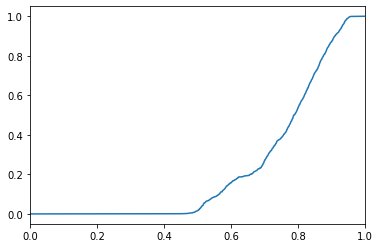

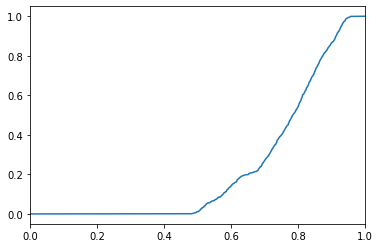

 90%|████████▉ | 850018/946094 [2:14:26<64:52:26,  2.43s/it]

Training AUC at epoch 0: 0.2359441818181818
Validation AUC epoch 0: 0.2362292727272727
Training Accuracy at epoch 0: 50.02047058823529
Validation Accuracy epoch 0: 49.97976470588235


 95%|█████████▌| 899990/946094 [2:21:07<06:43, 114.26it/s]  

 95%|█████████▌| 899990/946094 [2:21:24<06:43, 114.26it/s]

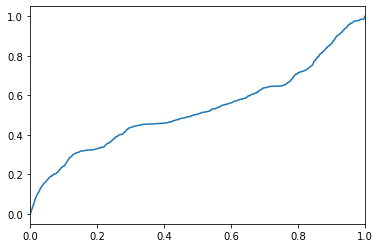

 95%|█████████▌| 900018/946094 [2:22:05<15:45:20,  1.23s/it]

Training AUC at epoch 0: 0.5262289090909091
Validation AUC epoch 0: 0.528339
Training Accuracy at epoch 0: 50.00266666666667
Validation Accuracy epoch 0: 49.98766666666667


  0%|          | 18/946094 [00:00<1:27:43, 179.74it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06252020.pth
Starting epoch: 1  with learning rate:  [0.1]


  0%|          | 3886/946094 [00:30<1:34:27, 166.25it/s]

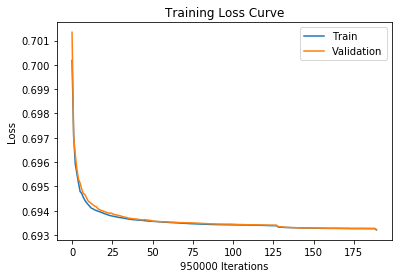

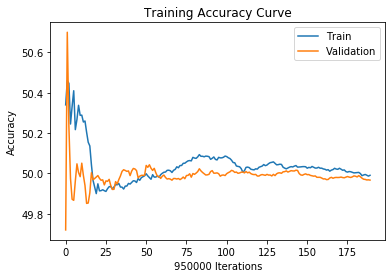

  0%|          | 3886/946094 [00:50<1:34:27, 166.25it/s]

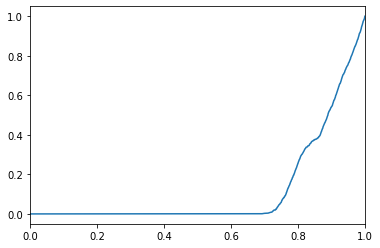

  0%|          | 3918/946094 [01:28<162:05:45,  1.61it/s]

Training AUC at epoch 1: 0.12120872727272727
Validation AUC epoch 1: 0.12380863636363637
Training Accuracy at epoch 1: 49.990736842105264
Validation Accuracy epoch 1: 49.96694736842105


  6%|▌         | 53900/946094 [08:13<1:54:25, 129.95it/s]

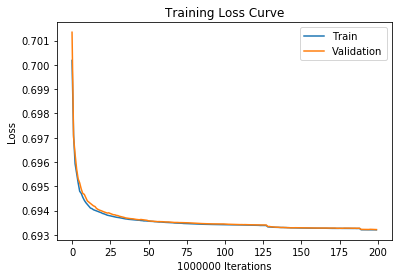

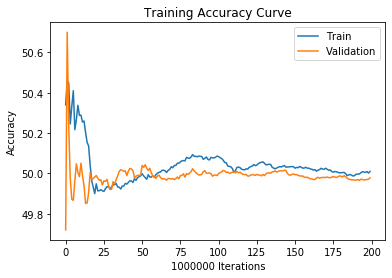

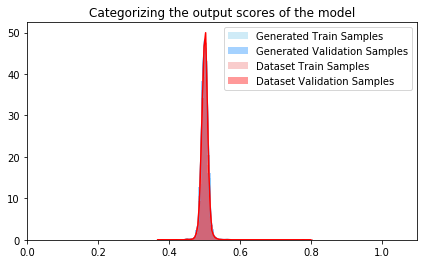

  6%|▌         | 53900/946094 [08:30<1:54:25, 129.95it/s]

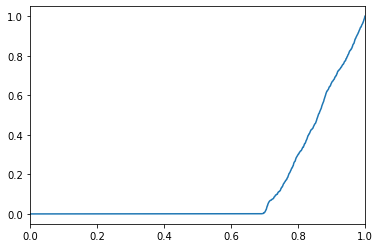

  6%|▌         | 53923/946094 [09:12<507:02:27,  2.05s/it]

Training AUC at epoch 1: 0.142895
Validation AUC epoch 1: 0.1408649090909091
Training Accuracy at epoch 1: 50.0098
Validation Accuracy epoch 1: 49.9776


 11%|█         | 103898/946094 [15:49<2:47:13, 83.93it/s] 

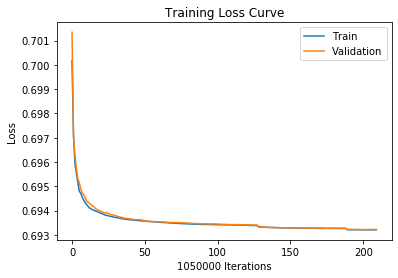

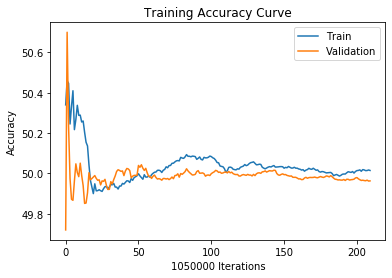

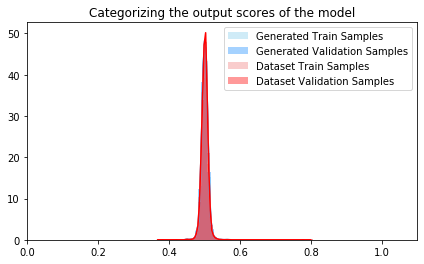

 11%|█         | 103898/946094 [16:00<2:47:13, 83.93it/s]

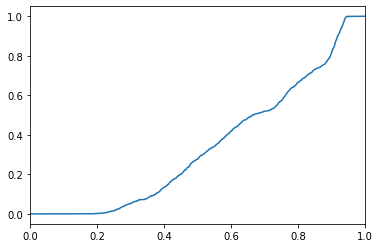

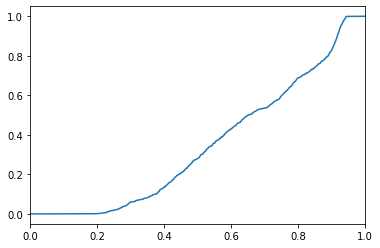

 11%|█         | 103924/946094 [16:47<359:16:55,  1.54s/it]

Training AUC at epoch 1: 0.3479272727272727
Validation AUC epoch 1: 0.34075863636363635
Training Accuracy at epoch 1: 50.014761904761905
Validation Accuracy epoch 1: 49.96304761904762


 16%|█▋        | 153894/946094 [23:24<1:32:38, 142.53it/s] 

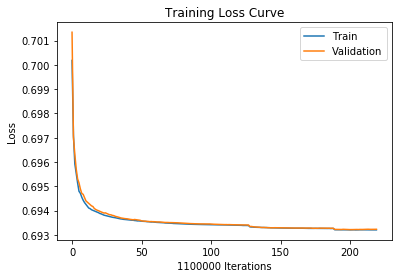

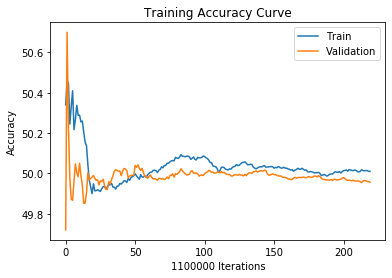

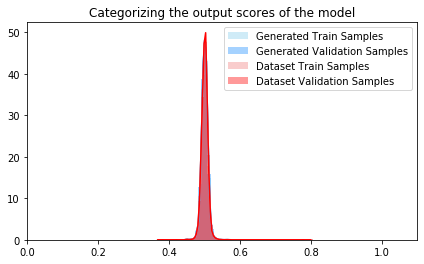

 16%|█▋        | 153894/946094 [23:40<1:32:38, 142.53it/s]

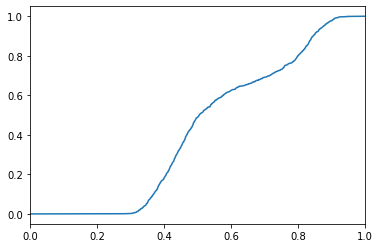

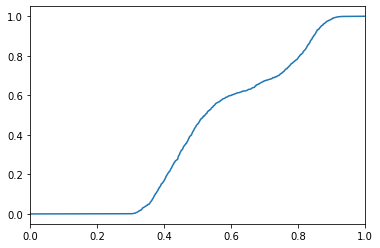

 16%|█▋        | 153924/946094 [24:23<226:49:47,  1.03s/it]

Training AUC at epoch 1: 0.4166229090909091
Validation AUC epoch 1: 0.4265429090909091
Training Accuracy at epoch 1: 50.01
Validation Accuracy epoch 1: 49.956545454545456


 22%|██▏       | 203904/946094 [30:57<1:47:04, 115.52it/s] 

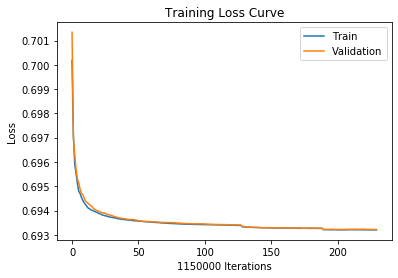

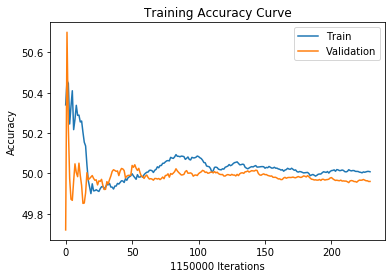

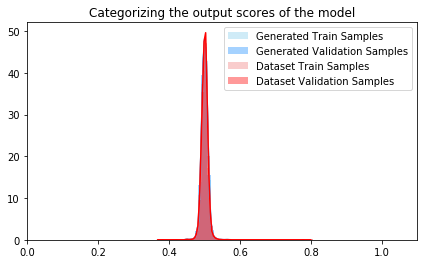

 22%|██▏       | 203904/946094 [31:11<1:47:04, 115.52it/s]

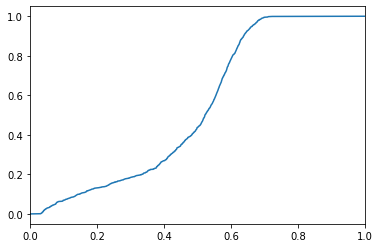

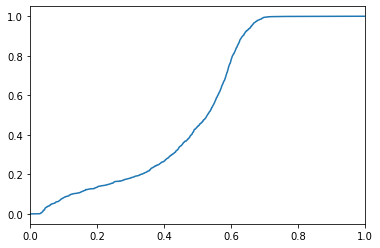

 22%|██▏       | 203923/946094 [31:56<1275:53:24,  6.19s/it]

Training AUC at epoch 1: 0.5362855454545454
Validation AUC epoch 1: 0.5362201818181819
Training Accuracy at epoch 1: 50.008347826086954
Validation Accuracy epoch 1: 49.96034782608696


 27%|██▋       | 253897/946094 [38:34<1:04:46, 178.08it/s]  

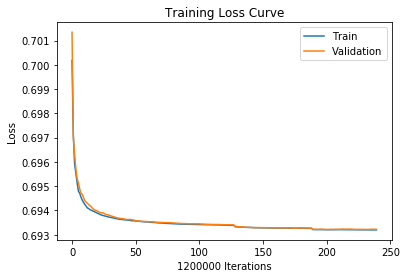

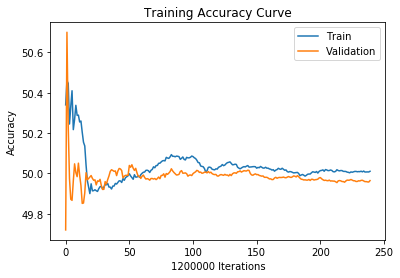

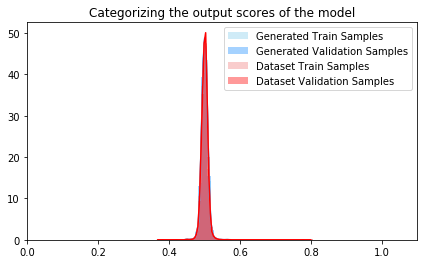

 27%|██▋       | 253897/946094 [38:51<1:04:46, 178.08it/s]

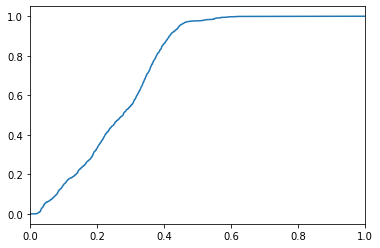

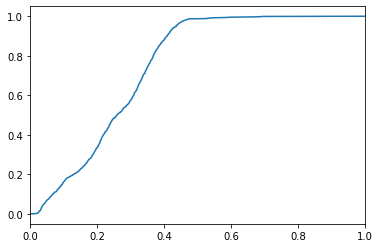

 27%|██▋       | 253922/946094 [39:33<266:22:43,  1.39s/it]

Training AUC at epoch 1: 0.7456961818181819
Validation AUC epoch 1: 0.7374644545454546
Training Accuracy at epoch 1: 50.01075
Validation Accuracy epoch 1: 49.964333333333336


 32%|███▏      | 303888/946094 [46:25<1:17:56, 137.32it/s] 

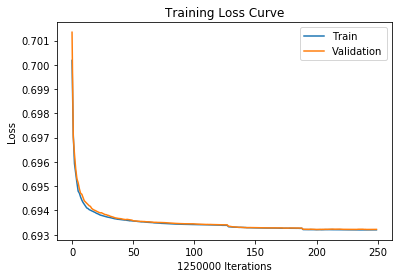

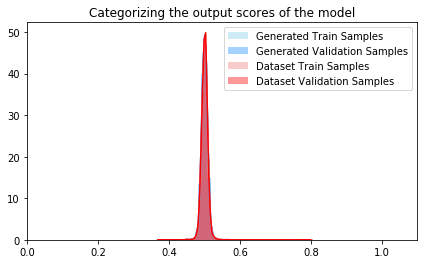

 32%|███▏      | 303888/946094 [46:41<1:17:56, 137.32it/s]

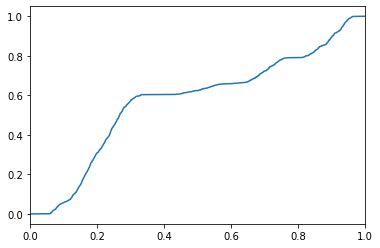

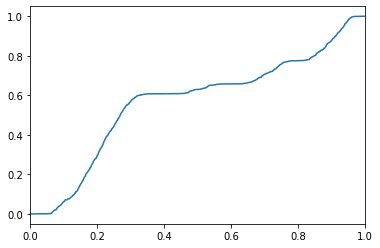

 32%|███▏      | 303925/946094 [47:24<124:18:13,  1.44it/s]

Training AUC at epoch 1: 0.5672319090909091
Validation AUC epoch 1: 0.5721523636363637
Training Accuracy at epoch 1: 50.00552
Validation Accuracy epoch 1: 49.95984


 37%|███▋      | 353887/946094 [54:06<1:56:39, 84.61it/s]  

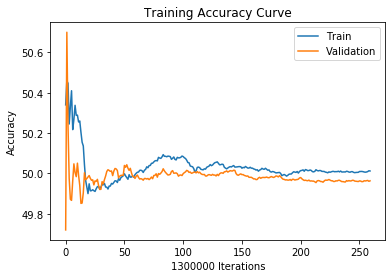

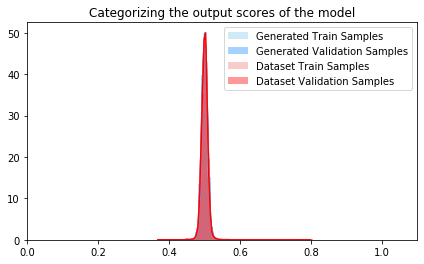

 37%|███▋      | 353887/946094 [54:22<1:56:39, 84.61it/s]

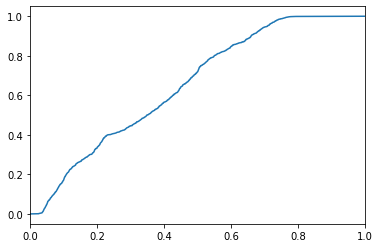

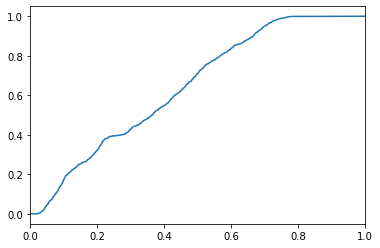

 37%|███▋      | 353924/946094 [55:07<110:38:10,  1.49it/s]

Training AUC at epoch 1: 0.6459755454545455
Validation AUC epoch 1: 0.6535059999999999
Training Accuracy at epoch 1: 50.01215384615384
Validation Accuracy epoch 1: 49.96338461538461


 43%|████▎     | 403898/946094 [1:01:38<59:20, 152.26it/s]  

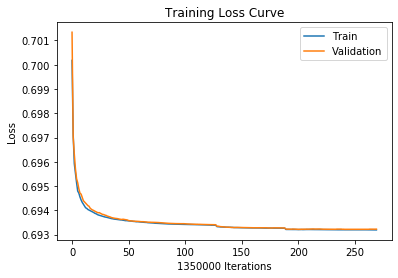

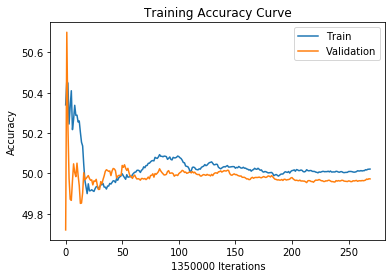

 43%|████▎     | 403898/946094 [1:01:52<59:20, 152.26it/s]

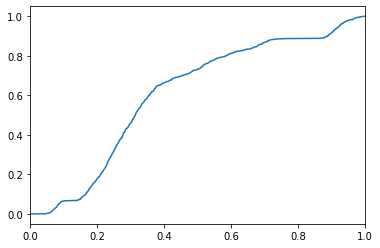

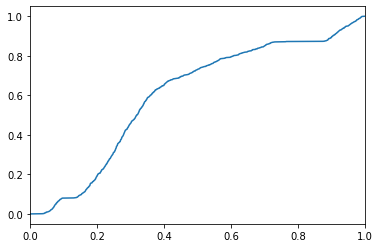

 43%|████▎     | 403906/946094 [1:02:38<339:54:27,  2.26s/it]

Training AUC at epoch 1: 0.6005683636363637
Validation AUC epoch 1: 0.6070531818181818
Training Accuracy at epoch 1: 50.0217037037037
Validation Accuracy epoch 1: 49.97288888888889


 48%|████▊     | 453891/946094 [1:09:09<1:10:11, 116.88it/s] 

 48%|████▊     | 453891/946094 [1:09:22<1:10:11, 116.88it/s]

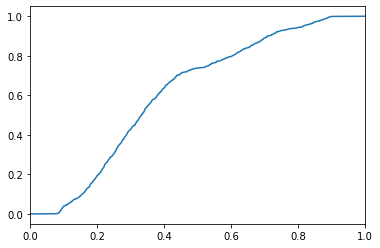

 48%|████▊     | 453924/946094 [1:10:11<117:42:58,  1.16it/s]

Training AUC at epoch 1: 0.6162755454545455
Validation AUC epoch 1: 0.6155229090909091
Training Accuracy at epoch 1: 50.029428571428575
Validation Accuracy epoch 1: 49.976


 53%|█████▎    | 503898/946094 [1:16:41<1:26:57, 84.74it/s]  

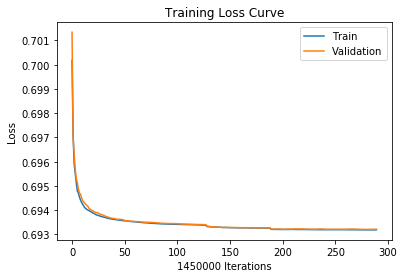

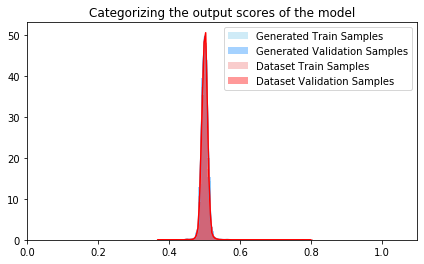

 53%|█████▎    | 503898/946094 [1:16:53<1:26:57, 84.74it/s]

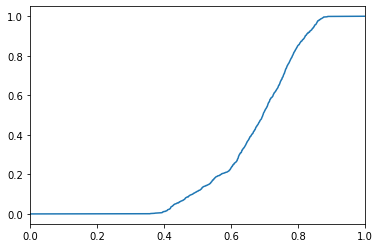

 53%|█████▎    | 503922/946094 [1:17:48<216:26:18,  1.76s/it]

Training AUC at epoch 1: 0.32385736363636364
Validation AUC epoch 1: 0.3286175454545454
Training Accuracy at epoch 1: 50.027655172413795
Validation Accuracy epoch 1: 49.964551724137934


 59%|█████▊    | 553887/946094 [1:24:32<43:33, 150.09it/s]   

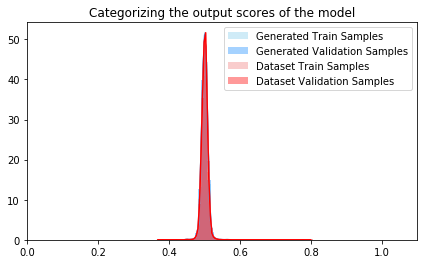

 59%|█████▊    | 553887/946094 [1:24:43<43:33, 150.09it/s]

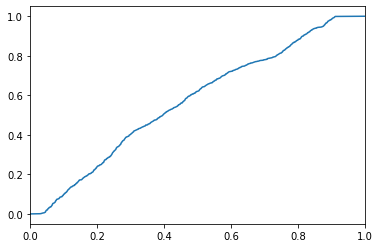

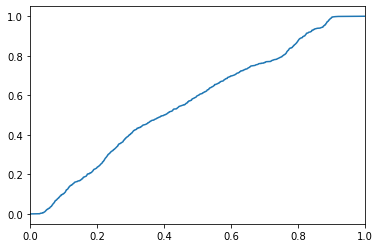

 59%|█████▊    | 553918/946094 [1:25:34<74:15:41,  1.47it/s] 

Training AUC at epoch 1: 0.5657370909090909
Validation AUC epoch 1: 0.5720057272727272
Training Accuracy at epoch 1: 50.0056
Validation Accuracy epoch 1: 49.971066666666665


 64%|██████▍   | 603893/946094 [1:32:26<56:29, 100.95it/s]  

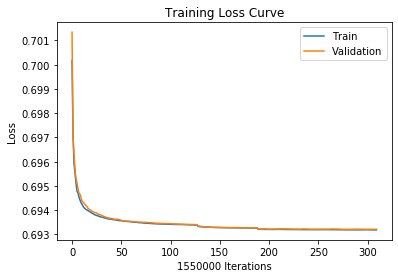

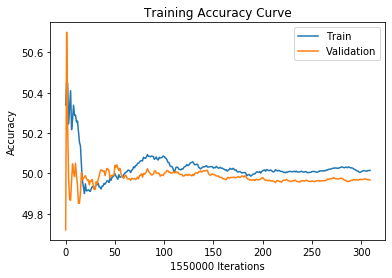

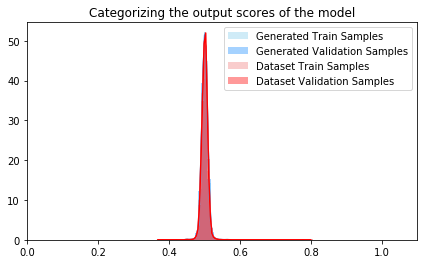

 64%|██████▍   | 603893/946094 [1:32:43<56:29, 100.95it/s]

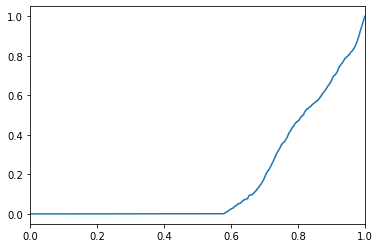

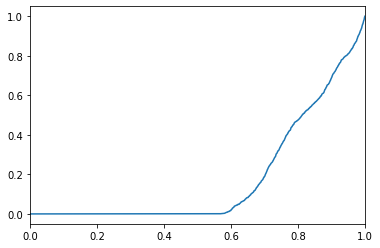

 64%|██████▍   | 603922/946094 [1:33:27<95:09:05,  1.00s/it] 

Training AUC at epoch 1: 0.18335627272727273
Validation AUC epoch 1: 0.18104627272727272
Training Accuracy at epoch 1: 50.015032258064515
Validation Accuracy epoch 1: 49.967677419354835


 69%|██████▉   | 653888/946094 [1:40:07<30:54, 157.54it/s]  

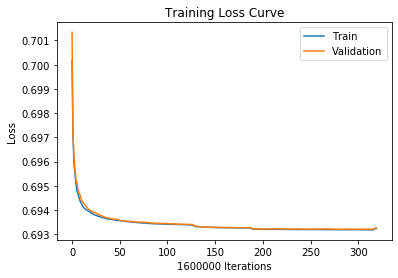

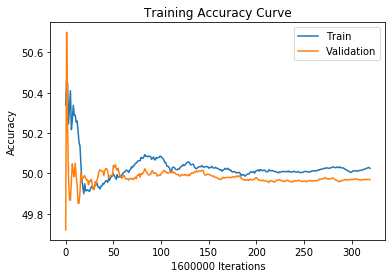

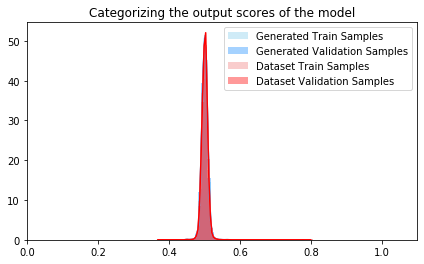

 69%|██████▉   | 653888/946094 [1:40:24<30:54, 157.54it/s]

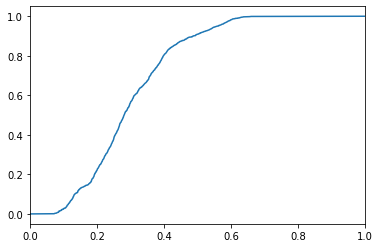

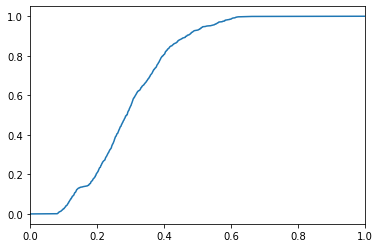

 69%|██████▉   | 653923/946094 [1:41:08<58:35:26,  1.39it/s]

Training AUC at epoch 1: 0.7016937272727274
Validation AUC epoch 1: 0.7001697272727273
Training Accuracy at epoch 1: 50.0251875
Validation Accuracy epoch 1: 49.9685625


 74%|███████▍  | 703901/946094 [1:47:42<28:43, 140.50it/s]  

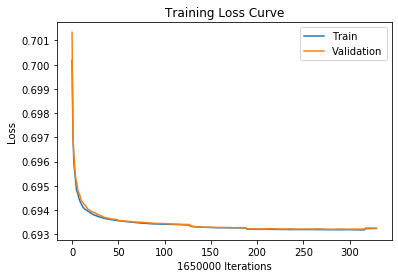

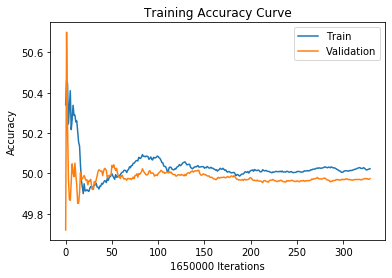

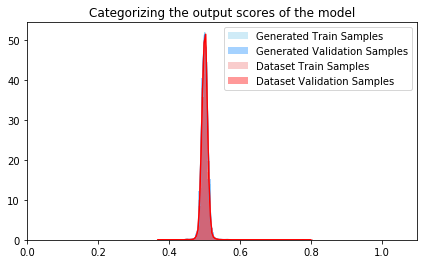

 74%|███████▍  | 703901/946094 [1:47:54<28:43, 140.50it/s]

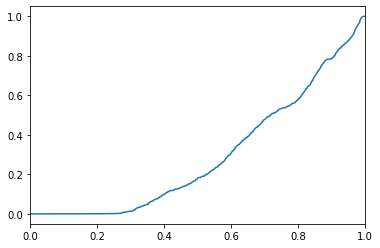

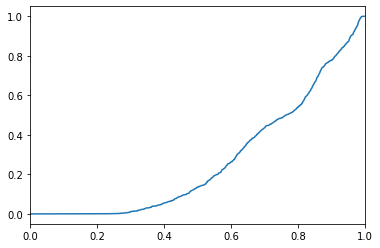

 74%|███████▍  | 703924/946094 [1:48:45<176:33:45,  2.62s/it]

Training AUC at epoch 1: 0.2707807272727273
Validation AUC epoch 1: 0.2930687272727273
Training Accuracy at epoch 1: 50.02351515151515
Validation Accuracy epoch 1: 49.97418181818182


 80%|███████▉  | 753905/946094 [1:55:18<31:49, 100.64it/s]   

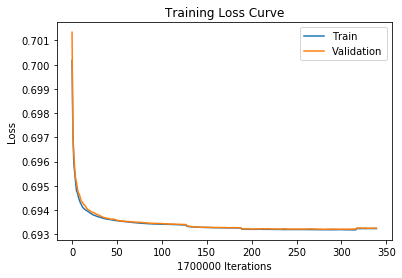

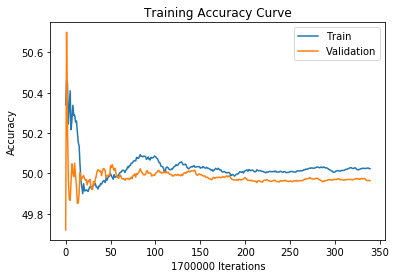

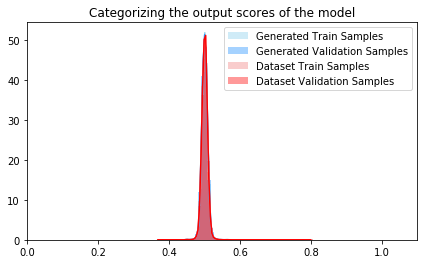

 80%|███████▉  | 753905/946094 [1:55:34<31:49, 100.64it/s]

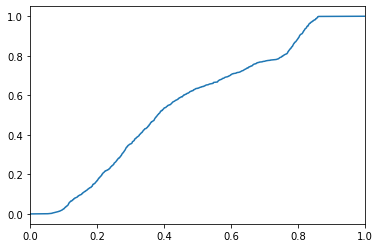

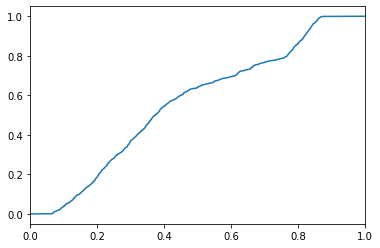

 80%|███████▉  | 753923/946094 [1:56:20<695:25:10, 13.03s/it]

Training AUC at epoch 1: 0.5603147272727272
Validation AUC epoch 1: 0.5577369090909091
Training Accuracy at epoch 1: 50.023411764705884
Validation Accuracy epoch 1: 49.96364705882353


 85%|████████▍ | 803893/946094 [2:02:53<14:23, 164.61it/s]   

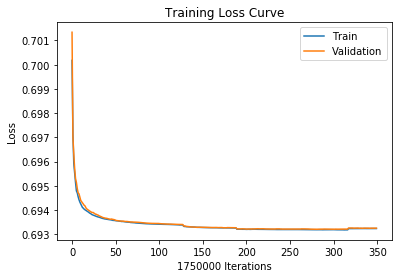

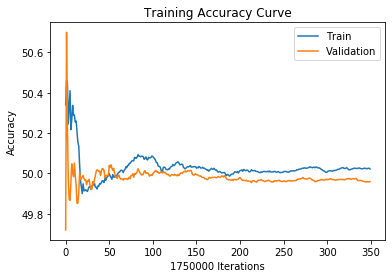

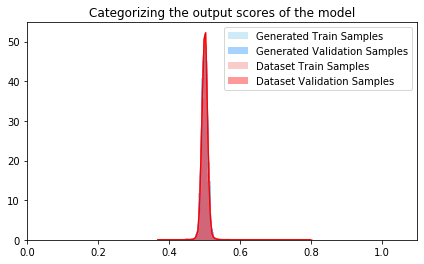

 85%|████████▍ | 803893/946094 [2:03:05<14:23, 164.61it/s]

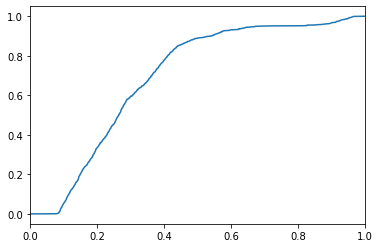

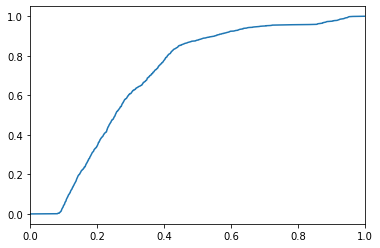

 85%|████████▍ | 803906/946094 [2:03:56<57:37:01,  1.46s/it]

Training AUC at epoch 1: 0.6978540909090909
Validation AUC epoch 1: 0.694135909090909
Training Accuracy at epoch 1: 50.022
Validation Accuracy epoch 1: 49.95988571428571


 90%|█████████ | 853885/946094 [2:10:42<11:18, 135.91it/s]  

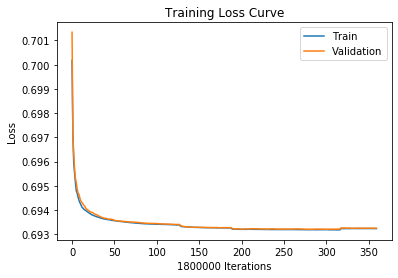

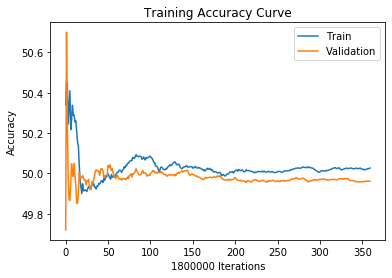

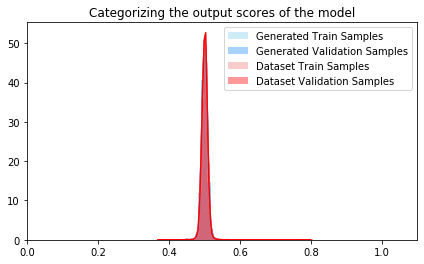

 90%|█████████ | 853885/946094 [2:10:55<11:18, 135.91it/s]

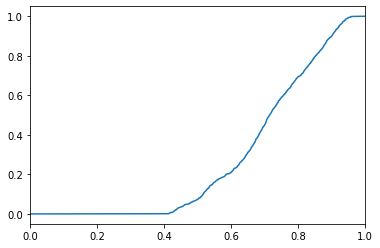

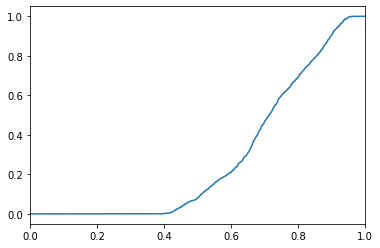

 90%|█████████ | 853924/946094 [2:11:46<16:16:35,  1.57it/s]

Training AUC at epoch 1: 0.28710854545454545
Validation AUC epoch 1: 0.28530436363636363
Training Accuracy at epoch 1: 50.02677777777778
Validation Accuracy epoch 1: 49.9615


 96%|█████████▌| 903890/946094 [2:18:37<08:19, 84.44it/s]   

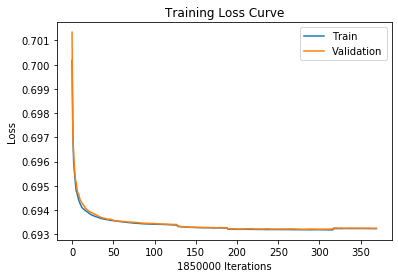

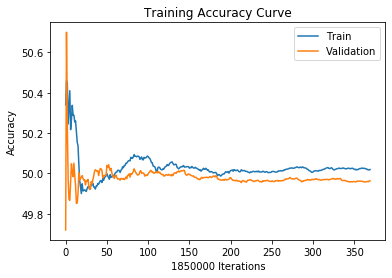

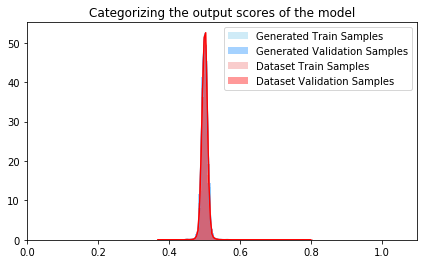

 96%|█████████▌| 903890/946094 [2:18:55<08:19, 84.44it/s]

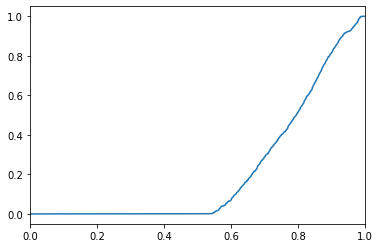

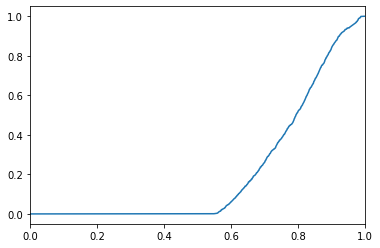

 96%|█████████▌| 903923/946094 [2:19:42<10:12:03,  1.15it/s]

Training AUC at epoch 1: 0.216899
Validation AUC epoch 1: 0.21831681818181817
Training Accuracy at epoch 1: 50.019351351351354
Validation Accuracy epoch 1: 49.96335135135135


  0%|          | 19/946094 [00:00<1:26:35, 182.10it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06252020.pth
Starting epoch: 2  with learning rate:  [0.1]


  1%|          | 7804/946094 [01:04<1:49:13, 143.16it/s]

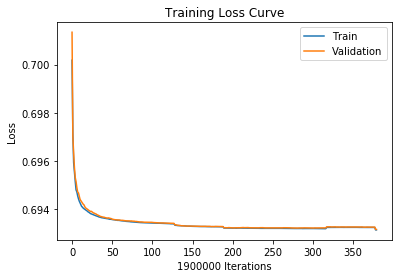

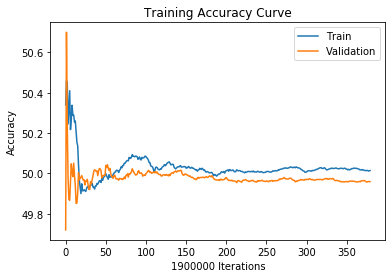

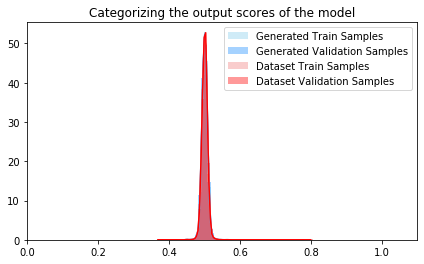

  1%|          | 7804/946094 [01:20<1:49:13, 143.16it/s]

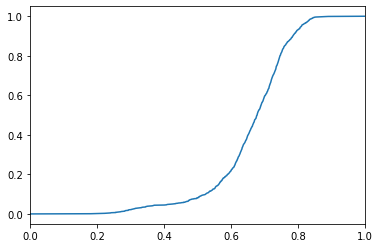

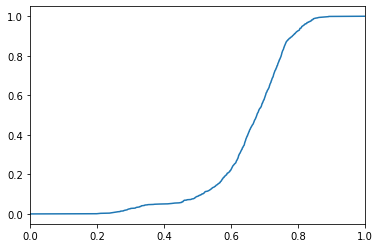

  1%|          | 7829/946094 [02:06<430:06:23,  1.65s/it]

Training AUC at epoch 2: 0.34258109090909095
Validation AUC epoch 2: 0.34126254545454543
Training Accuracy at epoch 2: 50.01436842105263
Validation Accuracy epoch 2: 49.95926315789474


  6%|▌         | 57802/946094 [08:36<2:07:50, 115.80it/s]

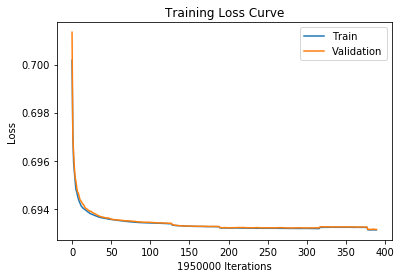

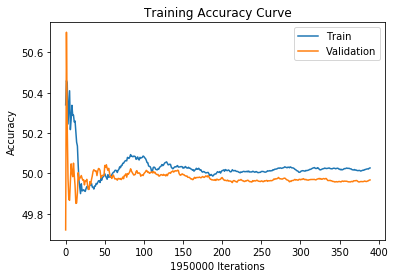

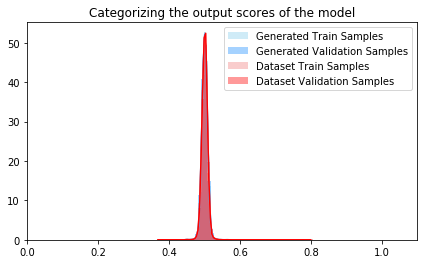

  6%|▌         | 57802/946094 [08:50<2:07:50, 115.80it/s]

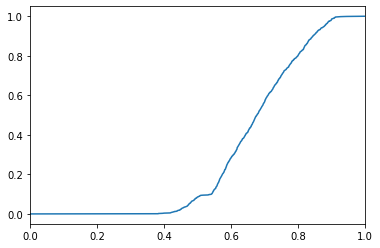

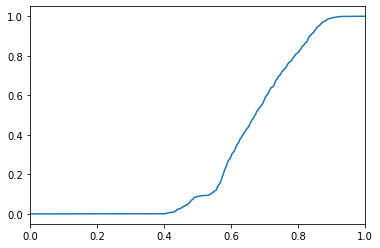

  6%|▌         | 57830/946094 [09:39<325:58:19,  1.32s/it]

Training AUC at epoch 2: 0.3247565454545454
Validation AUC epoch 2: 0.31994000000000006
Training Accuracy at epoch 2: 50.02723076923077
Validation Accuracy epoch 2: 49.96774358974359


 11%|█▏        | 107807/946094 [16:11<1:28:54, 157.15it/s]

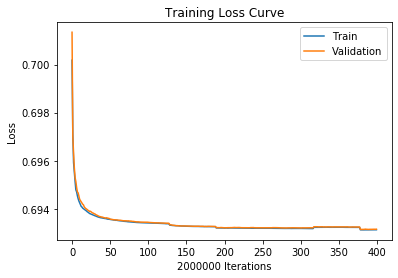

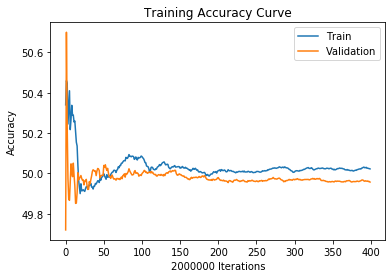

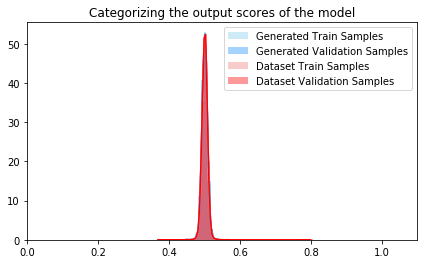

 11%|█▏        | 107807/946094 [16:30<1:28:54, 157.15it/s]

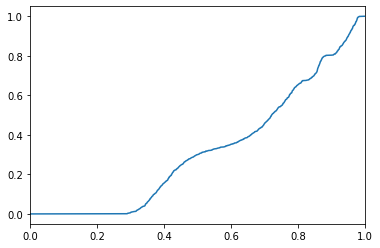

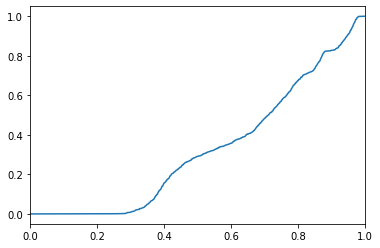

 11%|█▏        | 107829/946094 [17:16<633:15:08,  2.72s/it]

Training AUC at epoch 2: 0.3271838181818182
Validation AUC epoch 2: 0.321582
Training Accuracy at epoch 2: 50.0225
Validation Accuracy epoch 2: 49.9572


 17%|█▋        | 157794/946094 [23:52<1:35:52, 137.04it/s] 

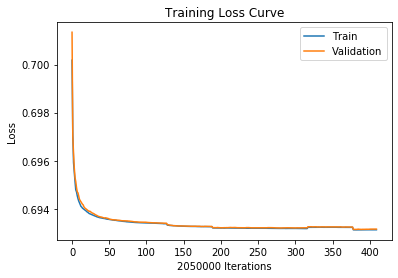

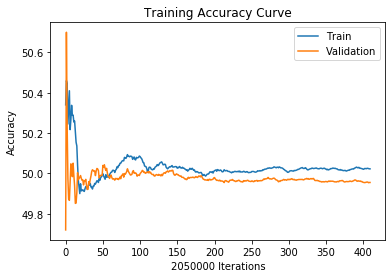

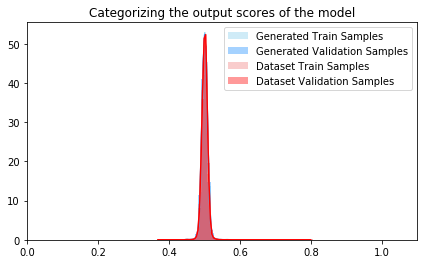

 17%|█▋        | 157794/946094 [24:11<1:35:52, 137.04it/s]

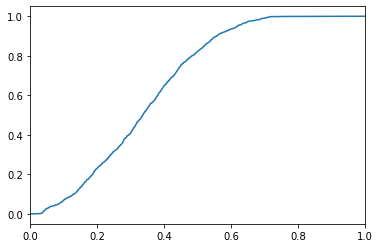

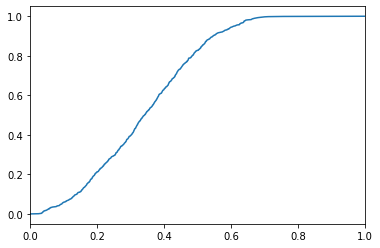

 17%|█▋        | 157829/946094 [24:56<164:19:03,  1.33it/s]

Training AUC at epoch 2: 0.6570297272727273
Validation AUC epoch 2: 0.6608580909090909
Training Accuracy at epoch 2: 50.02278048780488
Validation Accuracy epoch 2: 49.95521951219512


 22%|██▏       | 207810/946094 [31:42<1:43:00, 119.45it/s] 

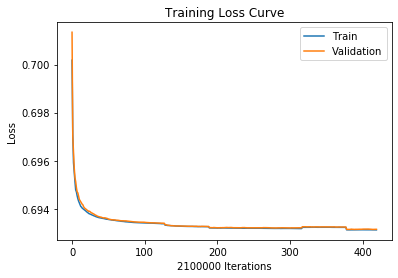

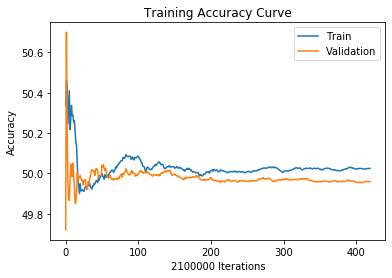

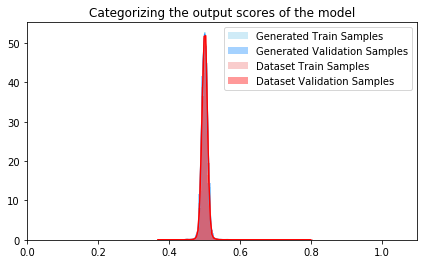

 22%|██▏       | 207810/946094 [32:01<1:43:00, 119.45it/s]

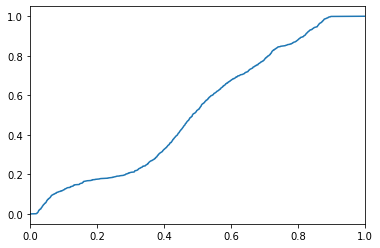

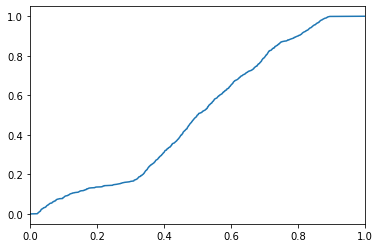

 22%|██▏       | 207830/946094 [32:46<1364:50:55,  6.66s/it]

Training AUC at epoch 2: 0.5040807272727272
Validation AUC epoch 2: 0.5204057272727272
Training Accuracy at epoch 2: 50.025285714285715
Validation Accuracy epoch 2: 49.959857142857146


 27%|██▋       | 257811/946094 [39:32<1:15:05, 152.76it/s]  

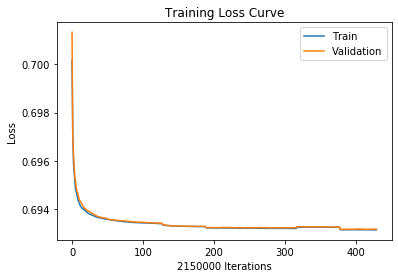

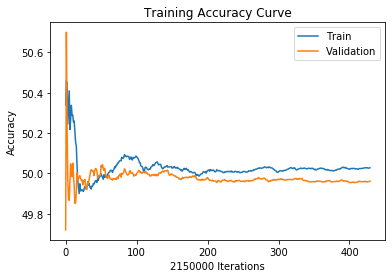

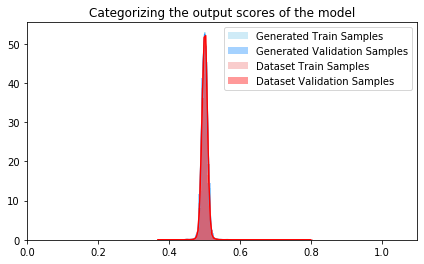

 27%|██▋       | 257811/946094 [39:51<1:15:05, 152.76it/s]

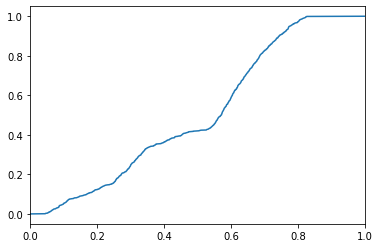

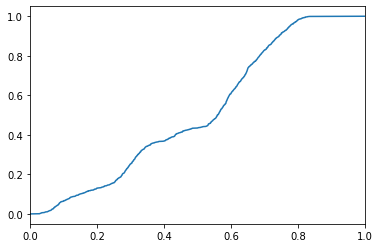

 27%|██▋       | 257812/946094 [40:37<3706:09:20, 19.38s/it]

Training AUC at epoch 2: 0.5158667272727273
Validation AUC epoch 2: 0.5085283636363636
Training Accuracy at epoch 2: 50.02818604651163
Validation Accuracy epoch 2: 49.96167441860465


 33%|███▎      | 307807/946094 [47:11<1:24:22, 126.08it/s]  

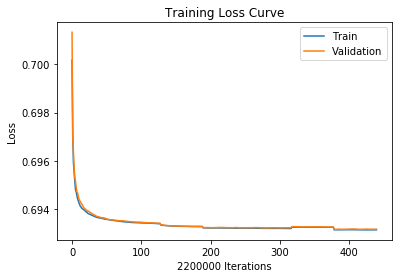

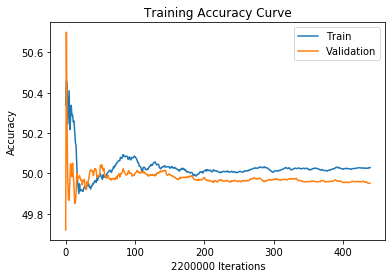

 33%|███▎      | 307807/946094 [47:22<1:24:22, 126.08it/s]

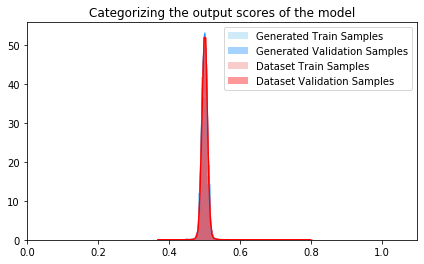

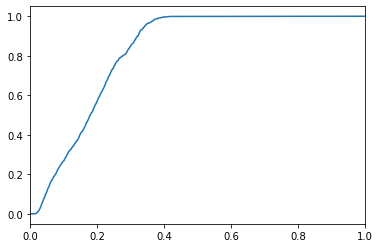

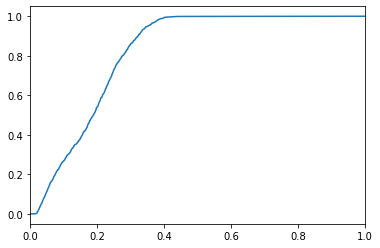

 33%|███▎      | 307830/946094 [48:16<483:05:55,  2.72s/it]

Training AUC at epoch 2: 0.8164919090909091
Validation AUC epoch 2: 0.8201971818181818
Training Accuracy at epoch 2: 50.02918181818182
Validation Accuracy epoch 2: 49.952363636363636


 38%|███▊      | 357805/946094 [54:48<1:56:12, 84.37it/s]  

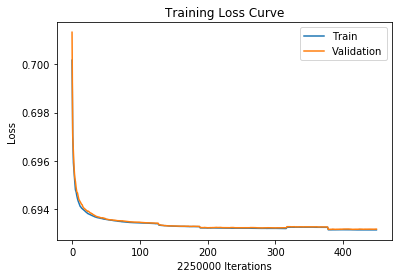

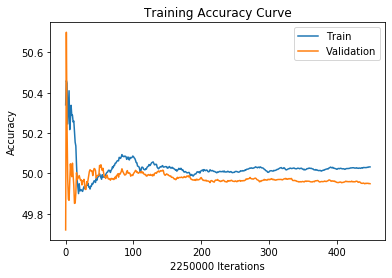

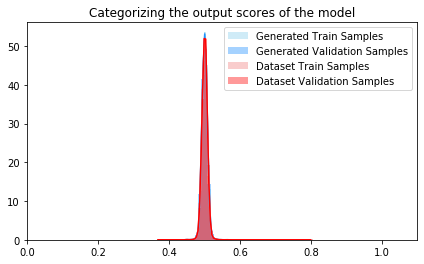

 38%|███▊      | 357805/946094 [55:02<1:56:12, 84.37it/s]

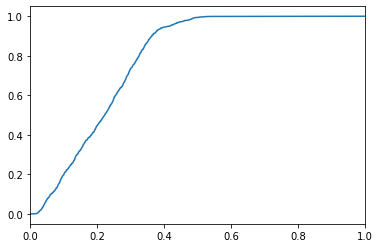

 38%|███▊      | 357829/946094 [55:53<316:53:36,  1.94s/it]

Training AUC at epoch 2: 0.780885
Validation AUC epoch 2: 0.7787537272727272
Training Accuracy at epoch 2: 50.032355555555554
Validation Accuracy epoch 2: 49.94911111111111


 43%|████▎     | 407811/946094 [1:02:31<59:15, 151.38it/s]  

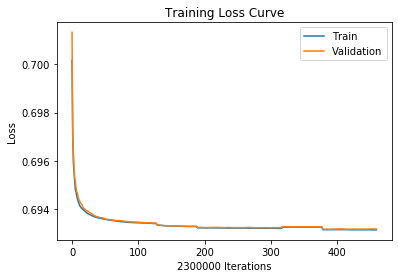

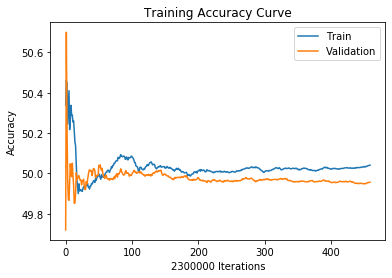

 43%|████▎     | 407811/946094 [1:02:42<59:15, 151.38it/s]

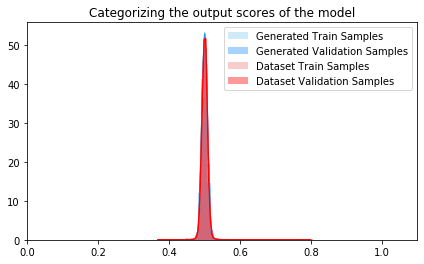

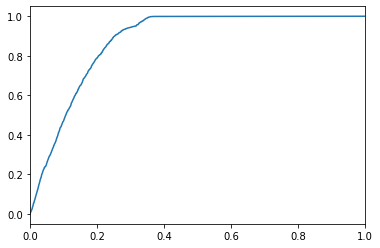

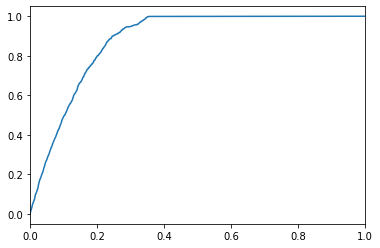

 43%|████▎     | 407829/946094 [1:03:36<2047:15:25, 13.69s/it]

Training AUC at epoch 2: 0.8800155454545453
Validation AUC epoch 2: 0.8764254545454545
Training Accuracy at epoch 2: 50.040695652173916
Validation Accuracy epoch 2: 49.95621739130435


 48%|████▊     | 457792/946094 [1:10:17<1:11:08, 114.40it/s]  

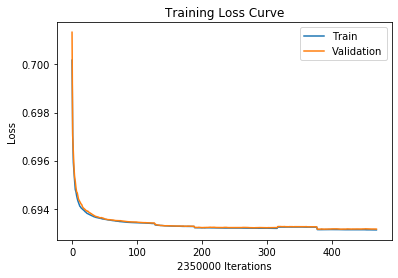

 48%|████▊     | 457792/946094 [1:10:33<1:11:08, 114.40it/s]

 48%|████▊     | 457829/946094 [1:11:24<95:53:35,  1.41it/s] 

Training AUC at epoch 2: 0.308098
Validation AUC epoch 2: 0.30165836363636367
Training Accuracy at epoch 2: 50.04285106382979
Validation Accuracy epoch 2: 49.956936170212764


 54%|█████▎    | 507795/946094 [1:18:12<42:08, 173.36it/s]  

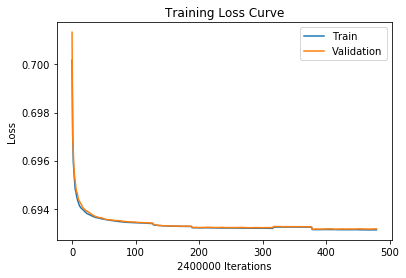

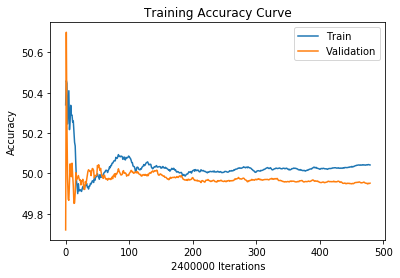

 54%|█████▎    | 507795/946094 [1:18:23<42:08, 173.36it/s]

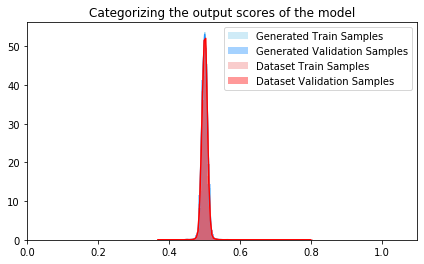

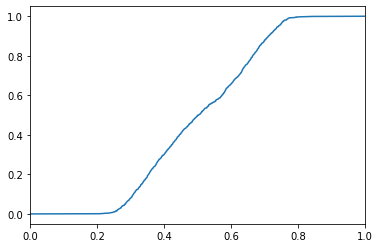

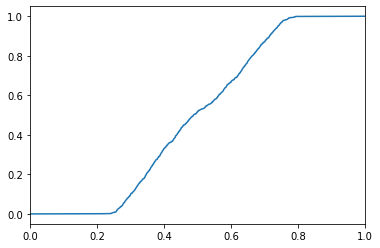

 54%|█████▎    | 507827/946094 [1:19:18<99:34:09,  1.22it/s] 

Training AUC at epoch 2: 0.49687409090909085
Validation AUC epoch 2: 0.49105136363636365
Training Accuracy at epoch 2: 50.042
Validation Accuracy epoch 2: 49.95175


 59%|█████▉    | 557810/946094 [1:26:05<45:55, 140.91it/s]  

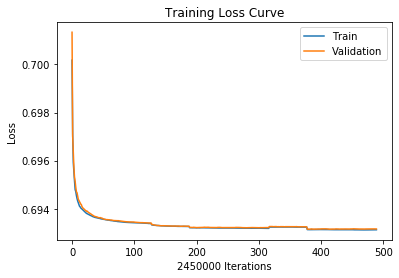

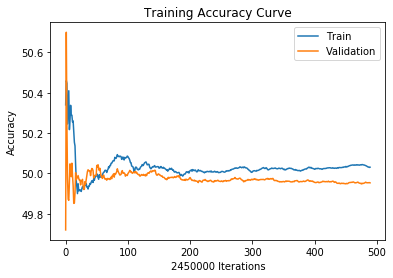

 59%|█████▉    | 557810/946094 [1:26:23<45:55, 140.91it/s]

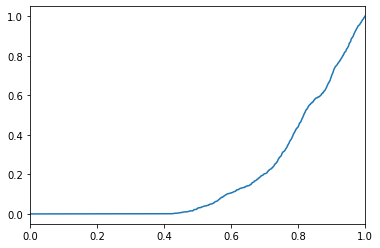

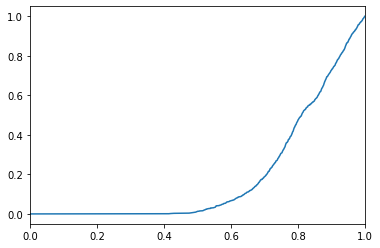

 59%|█████▉    | 557827/946094 [1:27:15<791:08:19,  7.34s/it] 

Training AUC at epoch 2: 0.1933631818181818
Validation AUC epoch 2: 0.19498563636363636
Training Accuracy at epoch 2: 50.030897959183676
Validation Accuracy epoch 2: 49.95330612244898


 64%|██████▍   | 607809/946094 [1:33:50<56:11, 100.34it/s]   

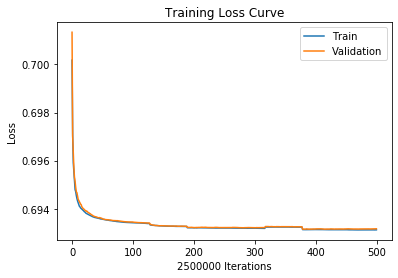

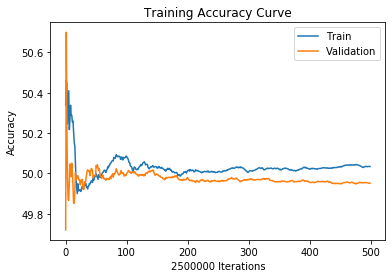

 64%|██████▍   | 607809/946094 [1:34:04<56:11, 100.34it/s]

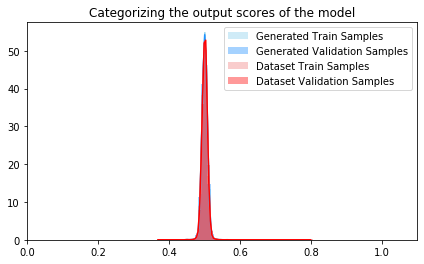

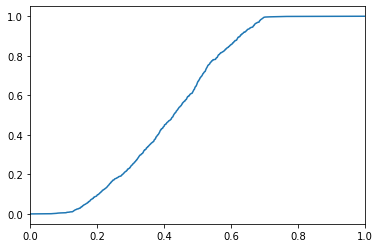

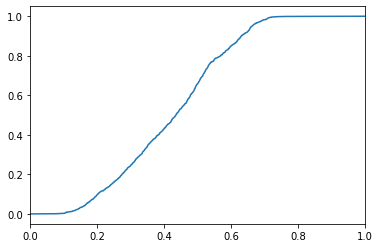

 64%|██████▍   | 607829/946094 [1:34:57<438:30:29,  4.67s/it]

Training AUC at epoch 2: 0.5769320909090909
Validation AUC epoch 2: 0.5796702727272727
Training Accuracy at epoch 2: 50.03444
Validation Accuracy epoch 2: 49.95188


 70%|██████▉   | 657803/946094 [1:41:31<31:37, 151.94it/s]   

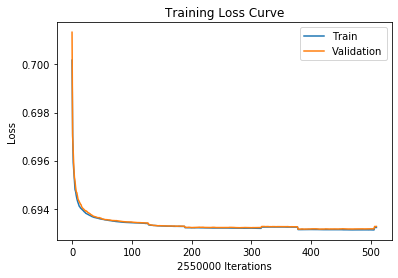

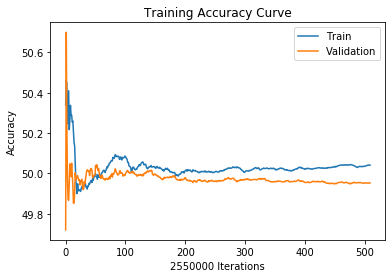

 70%|██████▉   | 657803/946094 [1:41:44<31:37, 151.94it/s]

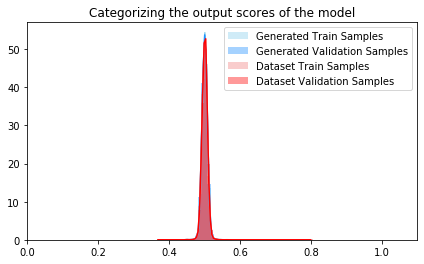

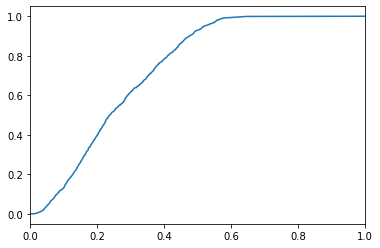

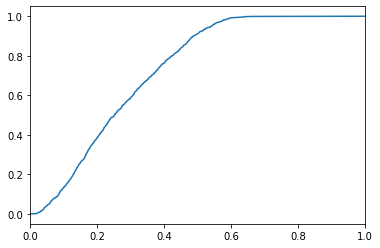

 70%|██████▉   | 657812/946094 [1:42:38<179:22:08,  2.24s/it]

Training AUC at epoch 2: 0.7275362727272727
Validation AUC epoch 2: 0.7355924545454546
Training Accuracy at epoch 2: 50.04078431372549
Validation Accuracy epoch 2: 49.952549019607844


 75%|███████▍  | 707807/946094 [1:49:13<30:18, 131.04it/s]   

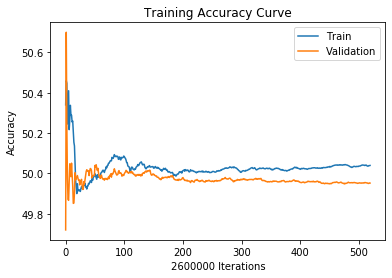

 75%|███████▍  | 707807/946094 [1:49:24<30:18, 131.04it/s]

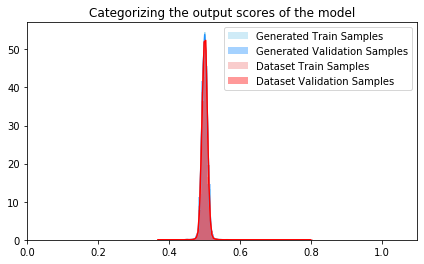

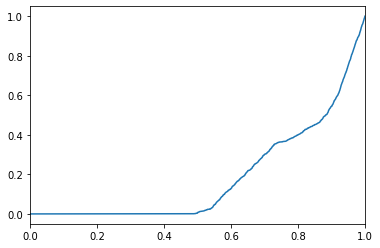

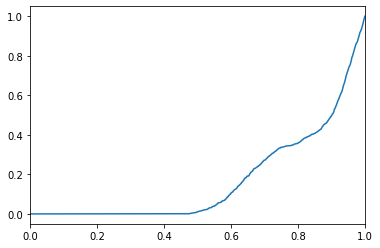

 75%|███████▍  | 707829/946094 [1:50:20<186:44:16,  2.82s/it]

Training AUC at epoch 2: 0.17133072727272727
Validation AUC epoch 2: 0.1843529090909091
Training Accuracy at epoch 2: 50.03957692307692
Validation Accuracy epoch 2: 49.95211538461538


 80%|████████  | 757804/946094 [1:57:04<37:32, 83.61it/s]    

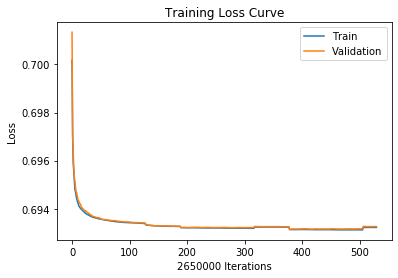

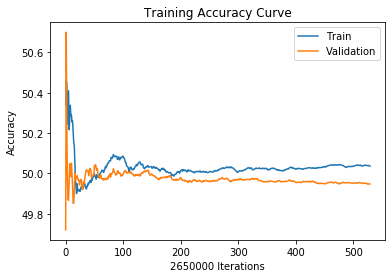

 80%|████████  | 757804/946094 [1:57:14<37:32, 83.61it/s]

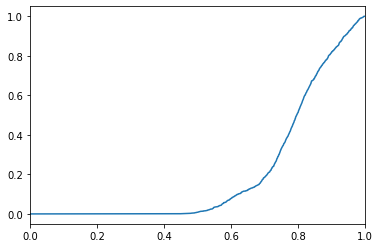

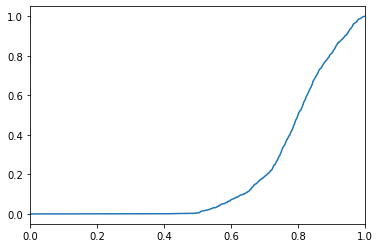

 80%|████████  | 757829/946094 [1:58:11<92:29:16,  1.77s/it] 

Training AUC at epoch 2: 0.207341
Validation AUC epoch 2: 0.20943290909090906
Training Accuracy at epoch 2: 50.03679245283019
Validation Accuracy epoch 2: 49.948113207547166


 85%|████████▌ | 807792/946094 [2:04:59<15:29, 148.78it/s]  

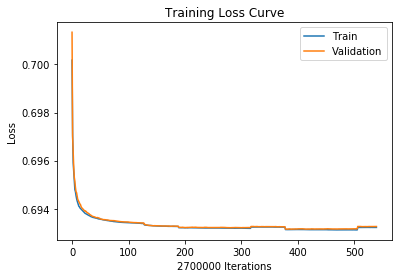

 85%|████████▌ | 807792/946094 [2:05:14<15:29, 148.78it/s]

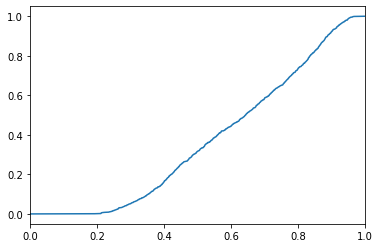

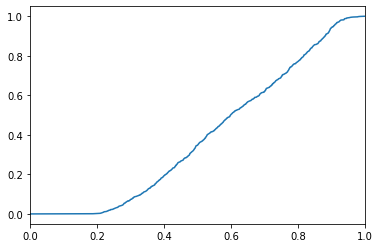

 85%|████████▌ | 807829/946094 [2:06:08<27:50:04,  1.38it/s]

Training AUC at epoch 2: 0.394649
Validation AUC epoch 2: 0.3720049999999999
Training Accuracy at epoch 2: 50.034962962962965
Validation Accuracy epoch 2: 49.943666666666665


 91%|█████████ | 857795/946094 [2:12:55<14:40, 100.32it/s]  

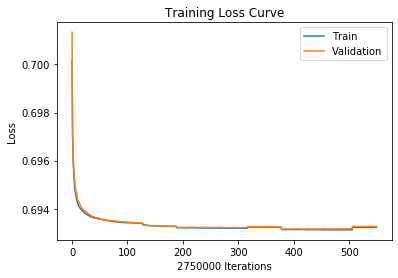

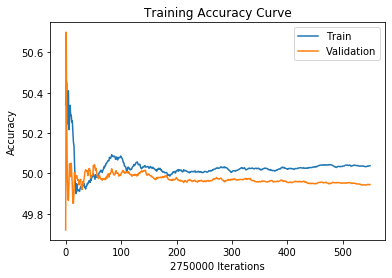

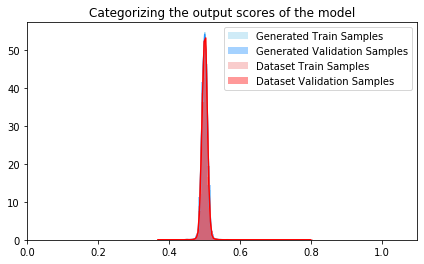

 91%|█████████ | 857795/946094 [2:13:14<14:40, 100.32it/s]

 91%|█████████ | 857832/946094 [2:14:03<20:43:56,  1.18it/s]

Training AUC at epoch 2: 0.6275723636363637
Validation AUC epoch 2: 0.6325933636363634
Training Accuracy at epoch 2: 50.038436363636364
Validation Accuracy epoch 2: 49.94483636363636


 96%|█████████▌| 907798/946094 [2:20:37<04:00, 159.55it/s]  

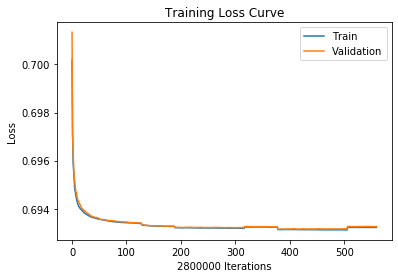

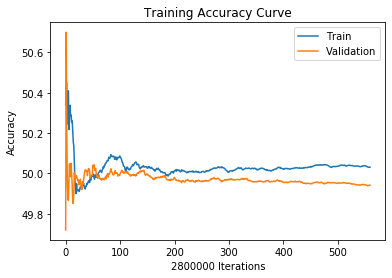

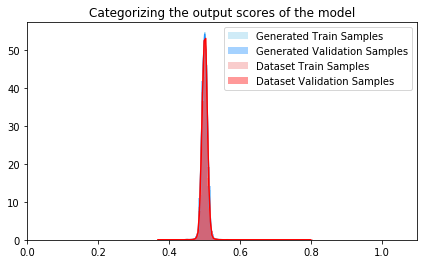

 96%|█████████▌| 907798/946094 [2:20:55<04:00, 159.55it/s]

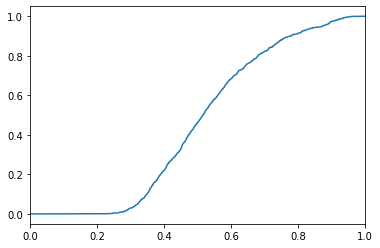

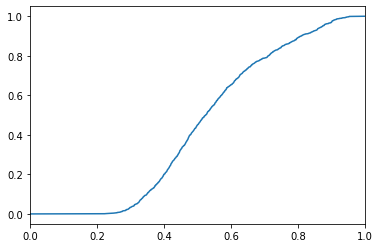

 96%|█████████▌| 907830/946094 [2:21:44<10:51:13,  1.02s/it]

Training AUC at epoch 2: 0.4493741818181818
Validation AUC epoch 2: 0.46042490909090905
Training Accuracy at epoch 2: 50.03060714285714
Validation Accuracy epoch 2: 49.94167857142857


  0%|          | 18/946094 [00:00<1:28:47, 177.59it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06252020.pth
Starting epoch: 3  with learning rate:  [0.08100000000000002]


  1%|          | 11711/946094 [01:38<1:59:36, 130.21it/s]

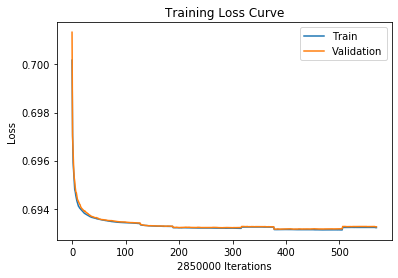

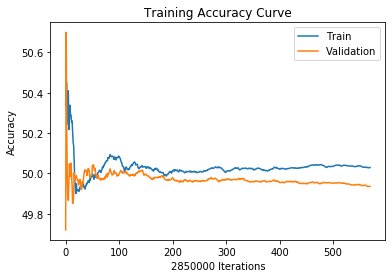

  1%|          | 11711/946094 [01:50<1:59:36, 130.21it/s]

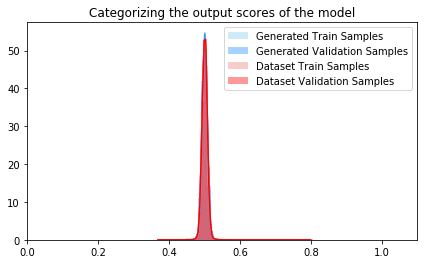

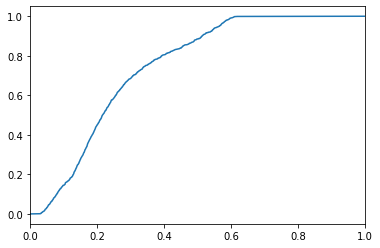

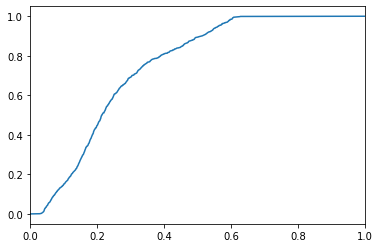

  1%|          | 11735/946094 [02:46<532:38:59,  2.05s/it]

Training AUC at epoch 3: 0.7468593636363636
Validation AUC epoch 3: 0.7445196363636364
Training Accuracy at epoch 3: 50.02961403508772
Validation Accuracy epoch 3: 49.935929824561406


  7%|▋         | 61711/946094 [09:17<2:26:55, 100.32it/s] 

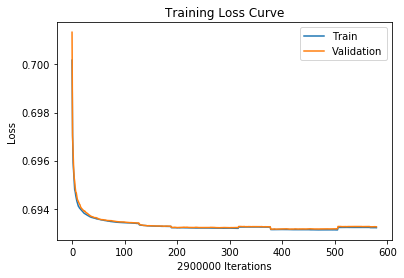

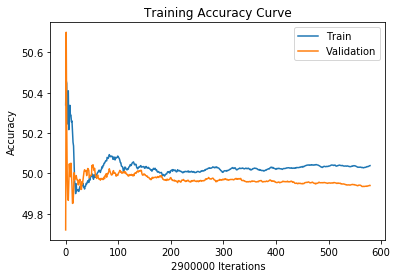

  7%|▋         | 61711/946094 [09:30<2:26:55, 100.32it/s]

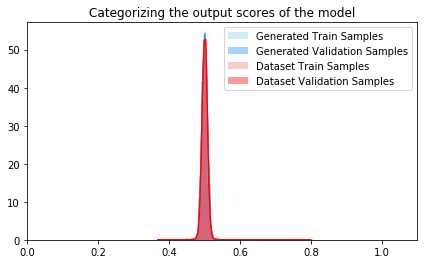

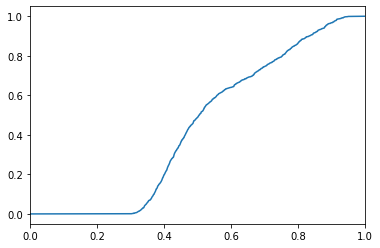

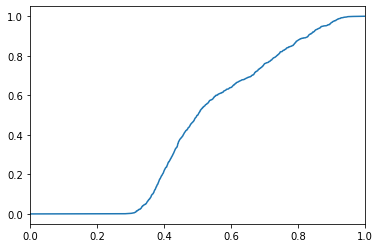

  7%|▋         | 61736/946094 [10:24<497:11:05,  2.02s/it]

Training AUC at epoch 3: 0.44638472727272727
Validation AUC epoch 3: 0.4412653636363636
Training Accuracy at epoch 3: 50.038758620689656
Validation Accuracy epoch 3: 49.940413793103446


 12%|█▏        | 111703/946094 [17:02<1:23:00, 167.54it/s]

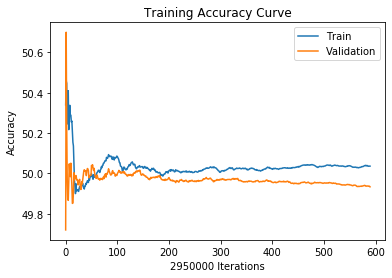

 12%|█▏        | 111703/946094 [17:20<1:23:00, 167.54it/s]

 12%|█▏        | 111718/946094 [18:11<318:32:01,  1.37s/it]

Training AUC at epoch 3: 0.3533259090909091
Validation AUC epoch 3: 0.35341072727272727
Training Accuracy at epoch 3: 50.03616949152542
Validation Accuracy epoch 3: 49.9335593220339


 17%|█▋        | 161698/946094 [24:59<1:35:19, 137.15it/s] 

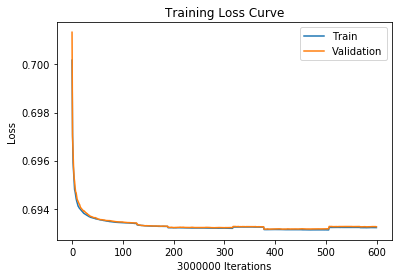

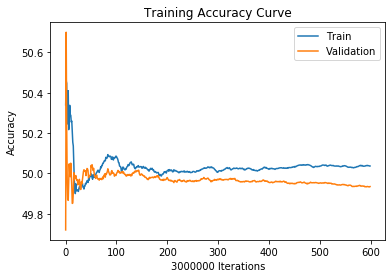

 17%|█▋        | 161698/946094 [25:10<1:35:19, 137.15it/s]

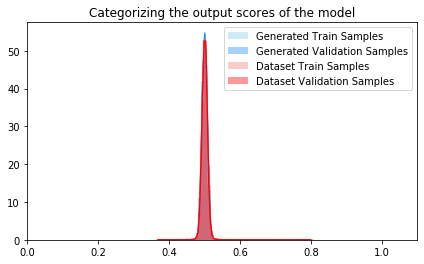

 17%|█▋        | 161733/946094 [26:08<158:49:13,  1.37it/s]

Training AUC at epoch 3: 0.5415591818181817
Validation AUC epoch 3: 0.5380337272727272
Training Accuracy at epoch 3: 50.03693333333333
Validation Accuracy epoch 3: 49.934733333333334


 22%|██▏       | 211712/946094 [32:50<2:26:38, 83.46it/s]  

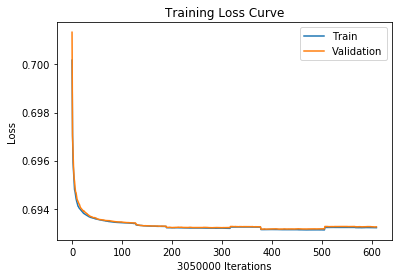

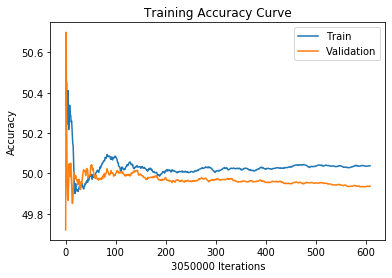

 22%|██▏       | 211712/946094 [33:00<2:26:38, 83.46it/s]

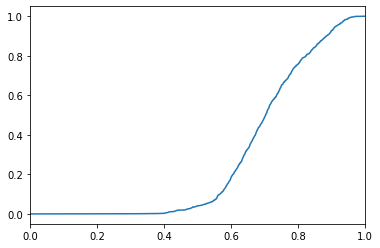

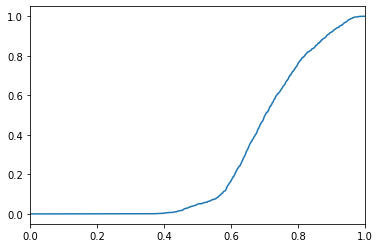

 22%|██▏       | 211738/946094 [33:59<497:13:18,  2.44s/it]

Training AUC at epoch 3: 0.28851618181818184
Validation AUC epoch 3: 0.2900705454545454
Training Accuracy at epoch 3: 50.03816393442623
Validation Accuracy epoch 3: 49.938065573770494


 28%|██▊       | 261713/946094 [40:31<1:19:27, 143.56it/s] 

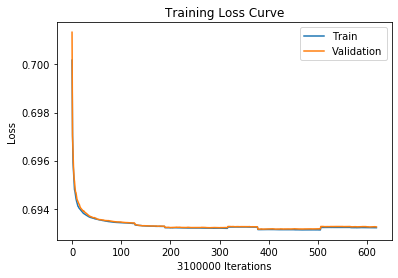

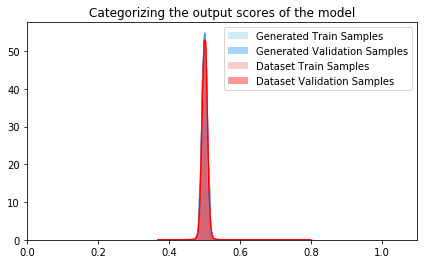

 28%|██▊       | 261713/946094 [40:50<1:19:27, 143.56it/s]

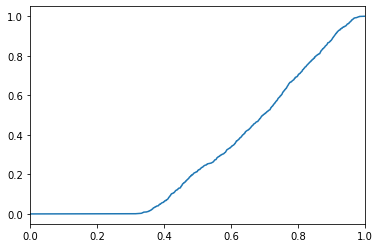

 28%|██▊       | 261736/946094 [41:40<547:15:10,  2.88s/it]

Training AUC at epoch 3: 0.32143209090909086
Validation AUC epoch 3: 0.3214830909090909
Training Accuracy at epoch 3: 50.03829032258064
Validation Accuracy epoch 3: 49.94096774193548


 33%|███▎      | 311705/946094 [48:07<1:44:19, 101.34it/s] 

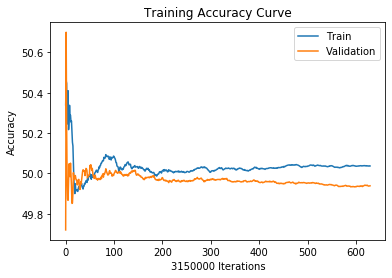

 33%|███▎      | 311705/946094 [48:21<1:44:19, 101.34it/s]

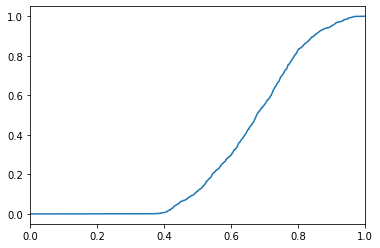

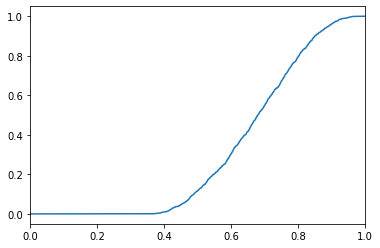

 33%|███▎      | 311735/946094 [49:18<201:07:58,  1.14s/it]

Training AUC at epoch 3: 0.3235957272727273
Validation AUC epoch 3: 0.3268568181818182
Training Accuracy at epoch 3: 50.037015873015875
Validation Accuracy epoch 3: 49.93873015873016


 38%|███▊      | 359426/946094 [55:26<1:37:02, 100.76it/s] 

In [ ]:
model = SingleAlphabetComplexNet()
model_name = model.name
model_id = "06252020"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
single_alphabet = True
cdf=False
NUM_EPOCHS = 50
BATCH_SIZE = 128
gamma = 1e-1
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path, cdf=cdf)